**Student**: Irene Testa

**E-mail**: i.testa@studenti.unipi.it

**Roll number**: 582061

# Midterm 1 - Assignment 2

*Identification of similarities and differences in the behaviour of the accelerometers of 15 people by means of ARMA models.*

Importing libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as sstats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
%matplotlib inline

## Data preparation

Loading data:

In [2]:
# defining constants
data_url = "https://raw.githubusercontent.com/iretes/ISPR/main/midterm-1/data/"
SAMPLING_FREQUENCY = 52
N_PARTICIPANTS = 15
N_ACTIVITIES = 7
descr2label = {
    "None": 0,
    "Working at Computer": 1,
    "Standing Up, Walking and Going up\down stairs": 2,
    "Standing": 3,
    "Walking": 4,
    "Going Up\Down Stairs": 5,
    "Walking and Talking with Someone": 6,
    "Talking while Standing": 7
}
RANDOM_STATE = 42
# loading data
data = pd.DataFrame()
for i in range(N_PARTICIPANTS):
    participant_data = pd.read_csv(data_url+f"{i+1}.csv", header=None, names=["time", "x", "y", "z", "label"])
    participant_data['participant'] = i+1
    data = pd.concat([data, participant_data])

Exploring the data:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1926896 entries, 0 to 103500
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   time         float64
 1   x            int64  
 2   y            int64  
 3   z            int64  
 4   label        int64  
 5   participant  int64  
dtypes: float64(1), int64(5)
memory usage: 102.9 MB


In [4]:
data.describe()

time             x             y             z         label  \
count  1.926896e+06  1.926896e+06  1.926896e+06  1.926896e+06  1.926896e+06   
mean   6.711283e+04  1.987652e+03  2.382523e+03  1.970596e+03  3.882898e+00   
std    4.146191e+04  1.113578e+02  1.003151e+02  9.445893e+01  2.443402e+00   
min    0.000000e+00  2.820000e+02  2.000000e+00  1.000000e+00  0.000000e+00   
25%    3.211400e+04  1.904000e+03  2.337000e+03  1.918000e+03  1.000000e+00   
50%    6.422900e+04  1.992000e+03  2.367000e+03  1.988000e+03  4.000000e+00   
75%    9.839400e+04  2.076000e+03  2.413000e+03  2.032000e+03  7.000000e+00   
max    1.667400e+05  3.828000e+03  4.095000e+03  4.095000e+03  7.000000e+00   

        participant  
count  1.926896e+06  
mean   7.512711e+00  
std    4.172396e+00  
min    1.000000e+00  
25%    4.000000e+00  
50%    7.000000e+00  
75%    1.100000e+01  
max    1.500000e+01

We will focus on the "Walking" activity. This decision was made after excluding labels encompassing multiple activities (e.g., "Standing Up, Walking, and Going up/down stairs") because of their non-stationary nature inhibiting the use of ARMA models, as well as those with almost constant signals (e.g., "Standing") that would not allow for the identification of differences between participants.

In [5]:
# keep only the label "Walking"
data = data[data["label"]==descr2label["Walking"]]
# sort by participant, label and time
data.sort_values(by=["participant", "label", "time"], inplace=True)

Checking for missing timestamps:

In [6]:
# check if timestamps are sequential and equally spaced
data.groupby(["participant"])["time"].diff().value_counts()

time
1.0    357049
Name: count, dtype: int64

There are no missing timestamps.

Reassigning timestamps to start from 0:

In [7]:
for i in range(1, N_PARTICIPANTS+1):
    data.loc[data["participant"]==i, "time"] = np.arange(0, data[data["participant"]==i].shape[0])

Visualizing the data:

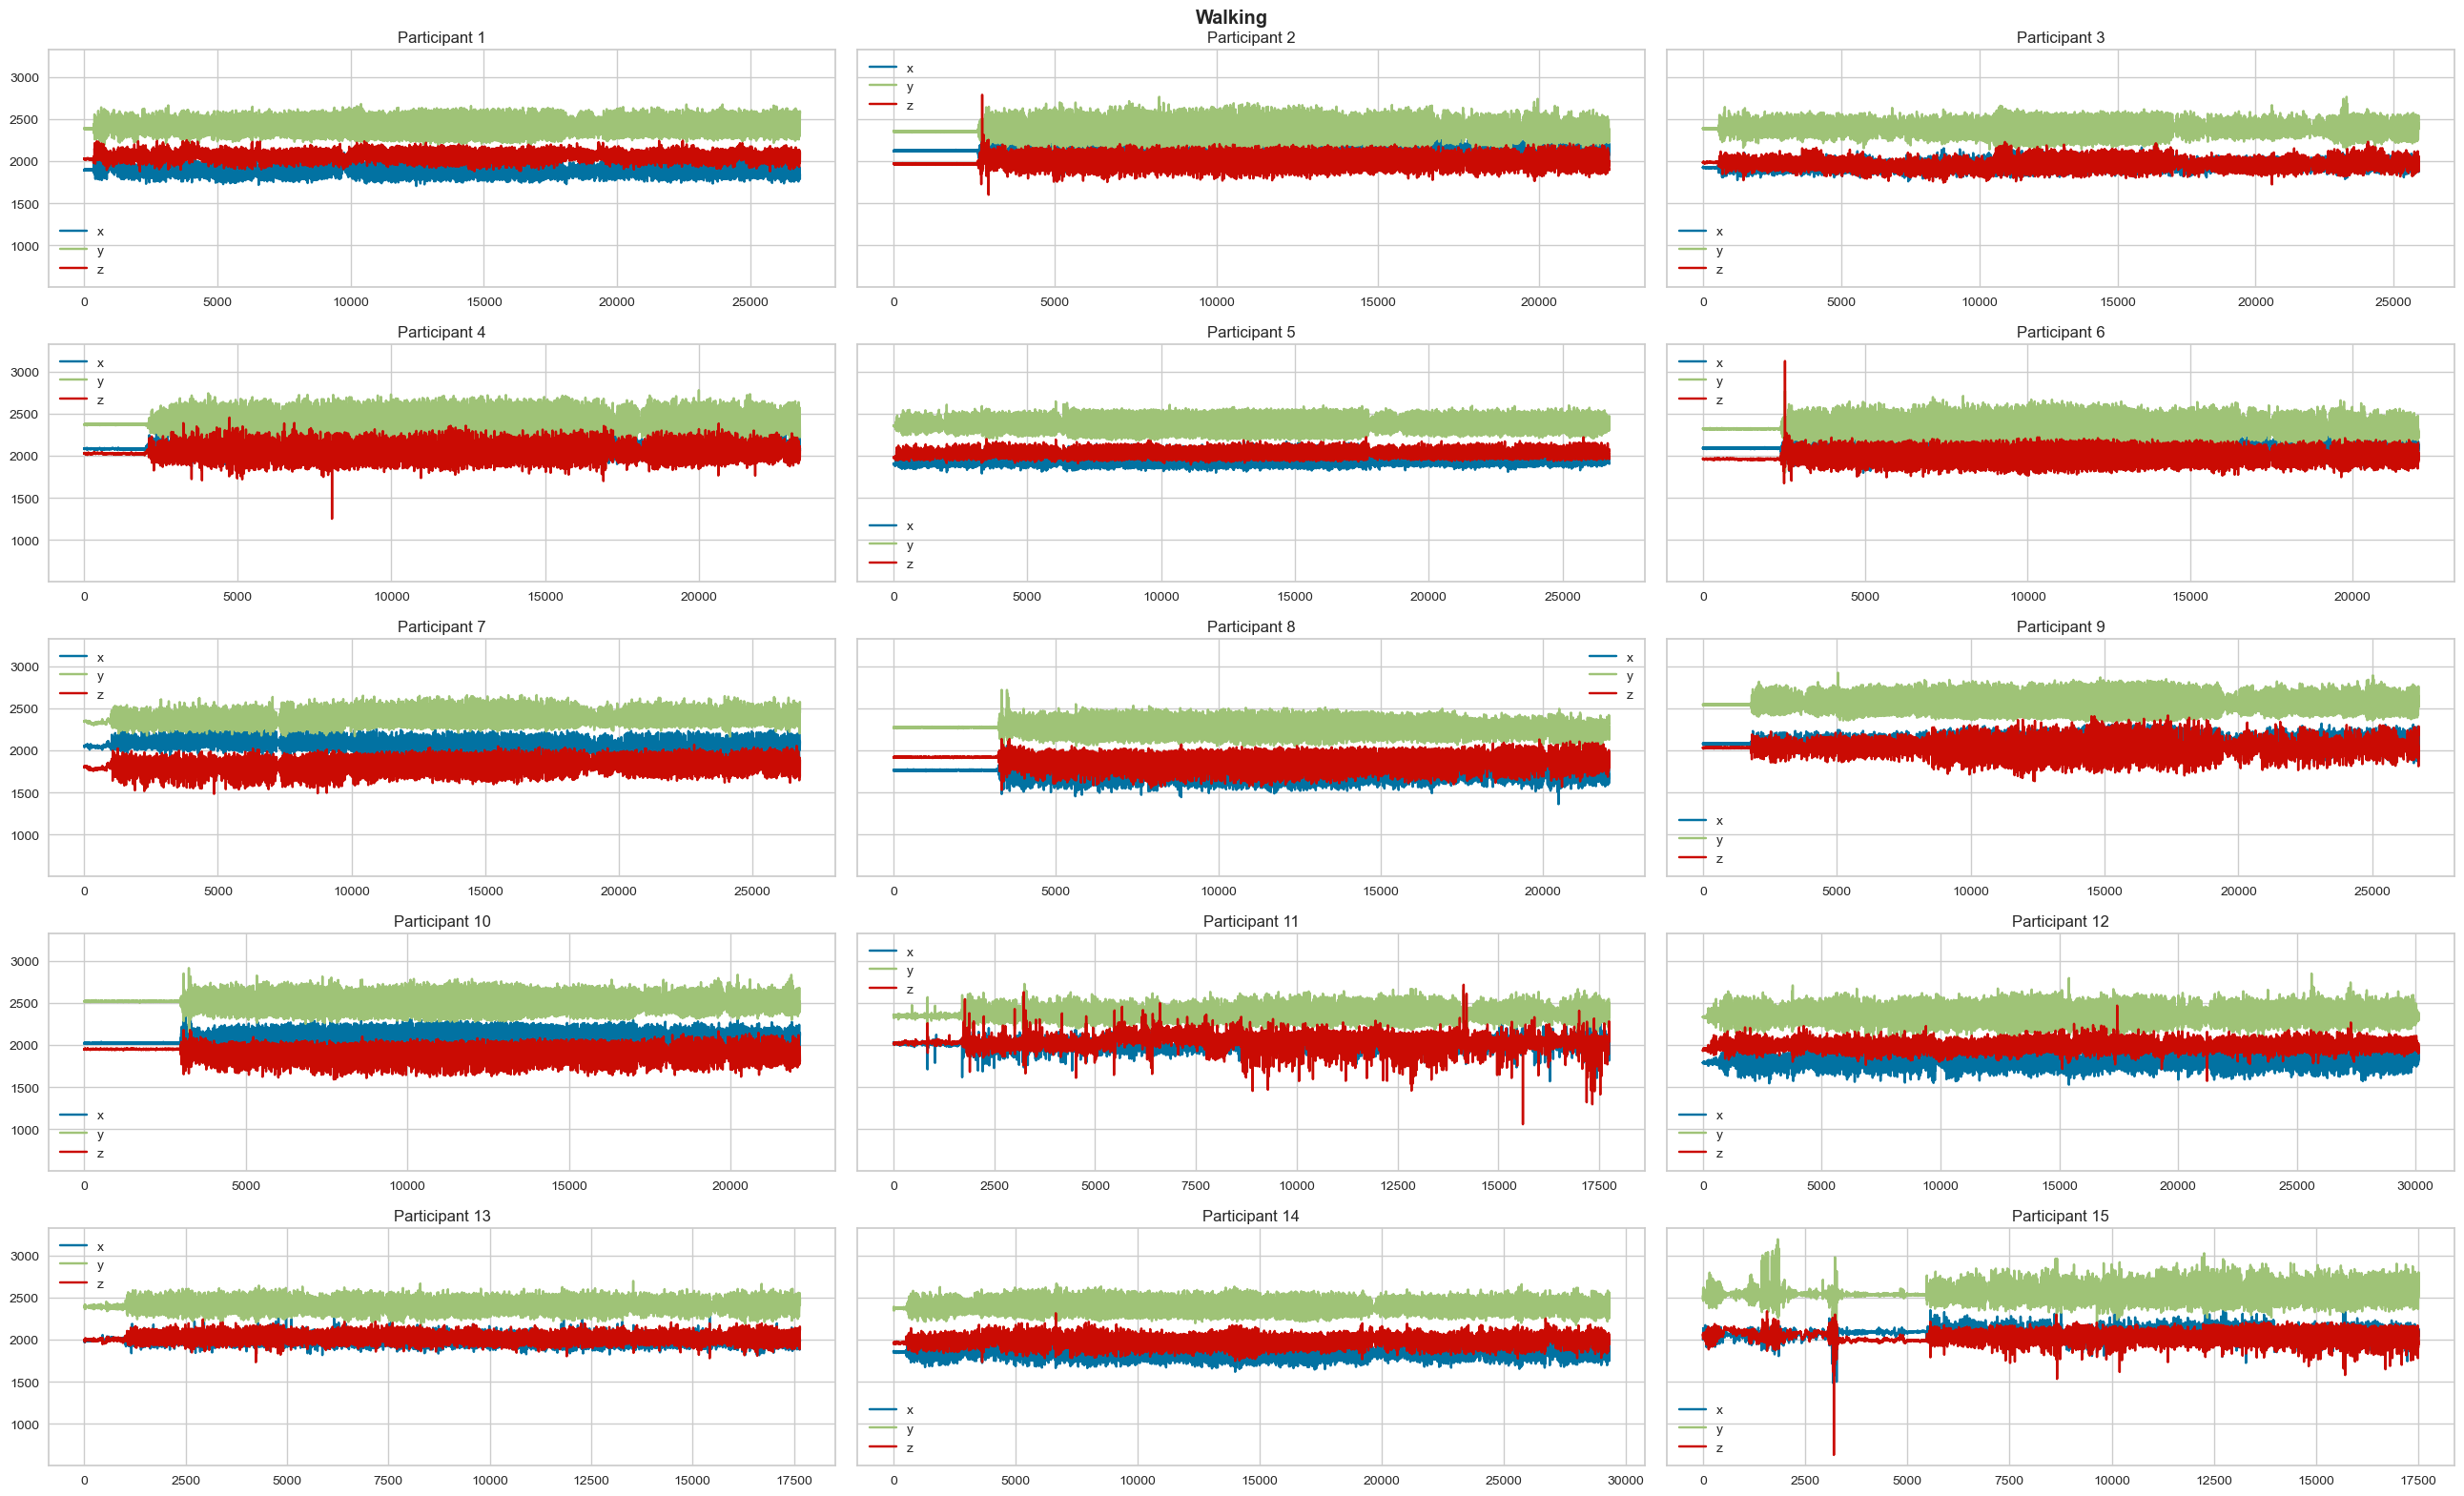

In [8]:
ncols = 3
nrows = 5
fig, axs = plt.subplots(nrows, ncols, figsize=(26, 16), sharey=True)
for i in range(N_PARTICIPANTS):
    axs[int(i/ncols)][i%ncols].set_title(f"Participant {i+1}")
    participant_data = data[(data["participant"]==i+1)]
    axs[int(i/ncols)][i%ncols].plot(participant_data["time"], participant_data["x"], label="x")
    axs[int(i/ncols)][i%ncols].plot(participant_data["time"], participant_data["y"], label="y")
    axs[int(i/ncols)][i%ncols].plot(participant_data["time"], participant_data["z"], label="z")
    axs[int(i/ncols)][i%ncols].legend()
fig.suptitle(f"Walking", fontweight="bold")
plt.tight_layout()

The first segment of the signal clearly shows the participant standing still. We cut the signal to only include the walking segment (starting timestamps were chosen by visual inspection, after zooming in on the signals):

In [9]:
# defining starting timestamps
start_times = [500, 3000, 750, 2250, 200, 2750, 1100, 3500, 2000, 3100, 1900, 800, 1200, 750, 5750]
# removing samples with time stamp < start_times
for i in range(N_PARTICIPANTS):
    data = data[~((data["participant"]==i+1)&(data["time"]<start_times[i]))]
# reassigning time stamps to start from 0
for i in range(1, N_PARTICIPANTS+1):
    data.loc[data["participant"]==i, "time"] = np.arange(0, data[data["participant"]==i].shape[0])

Visualization of the initial segment of the time series after the cut:

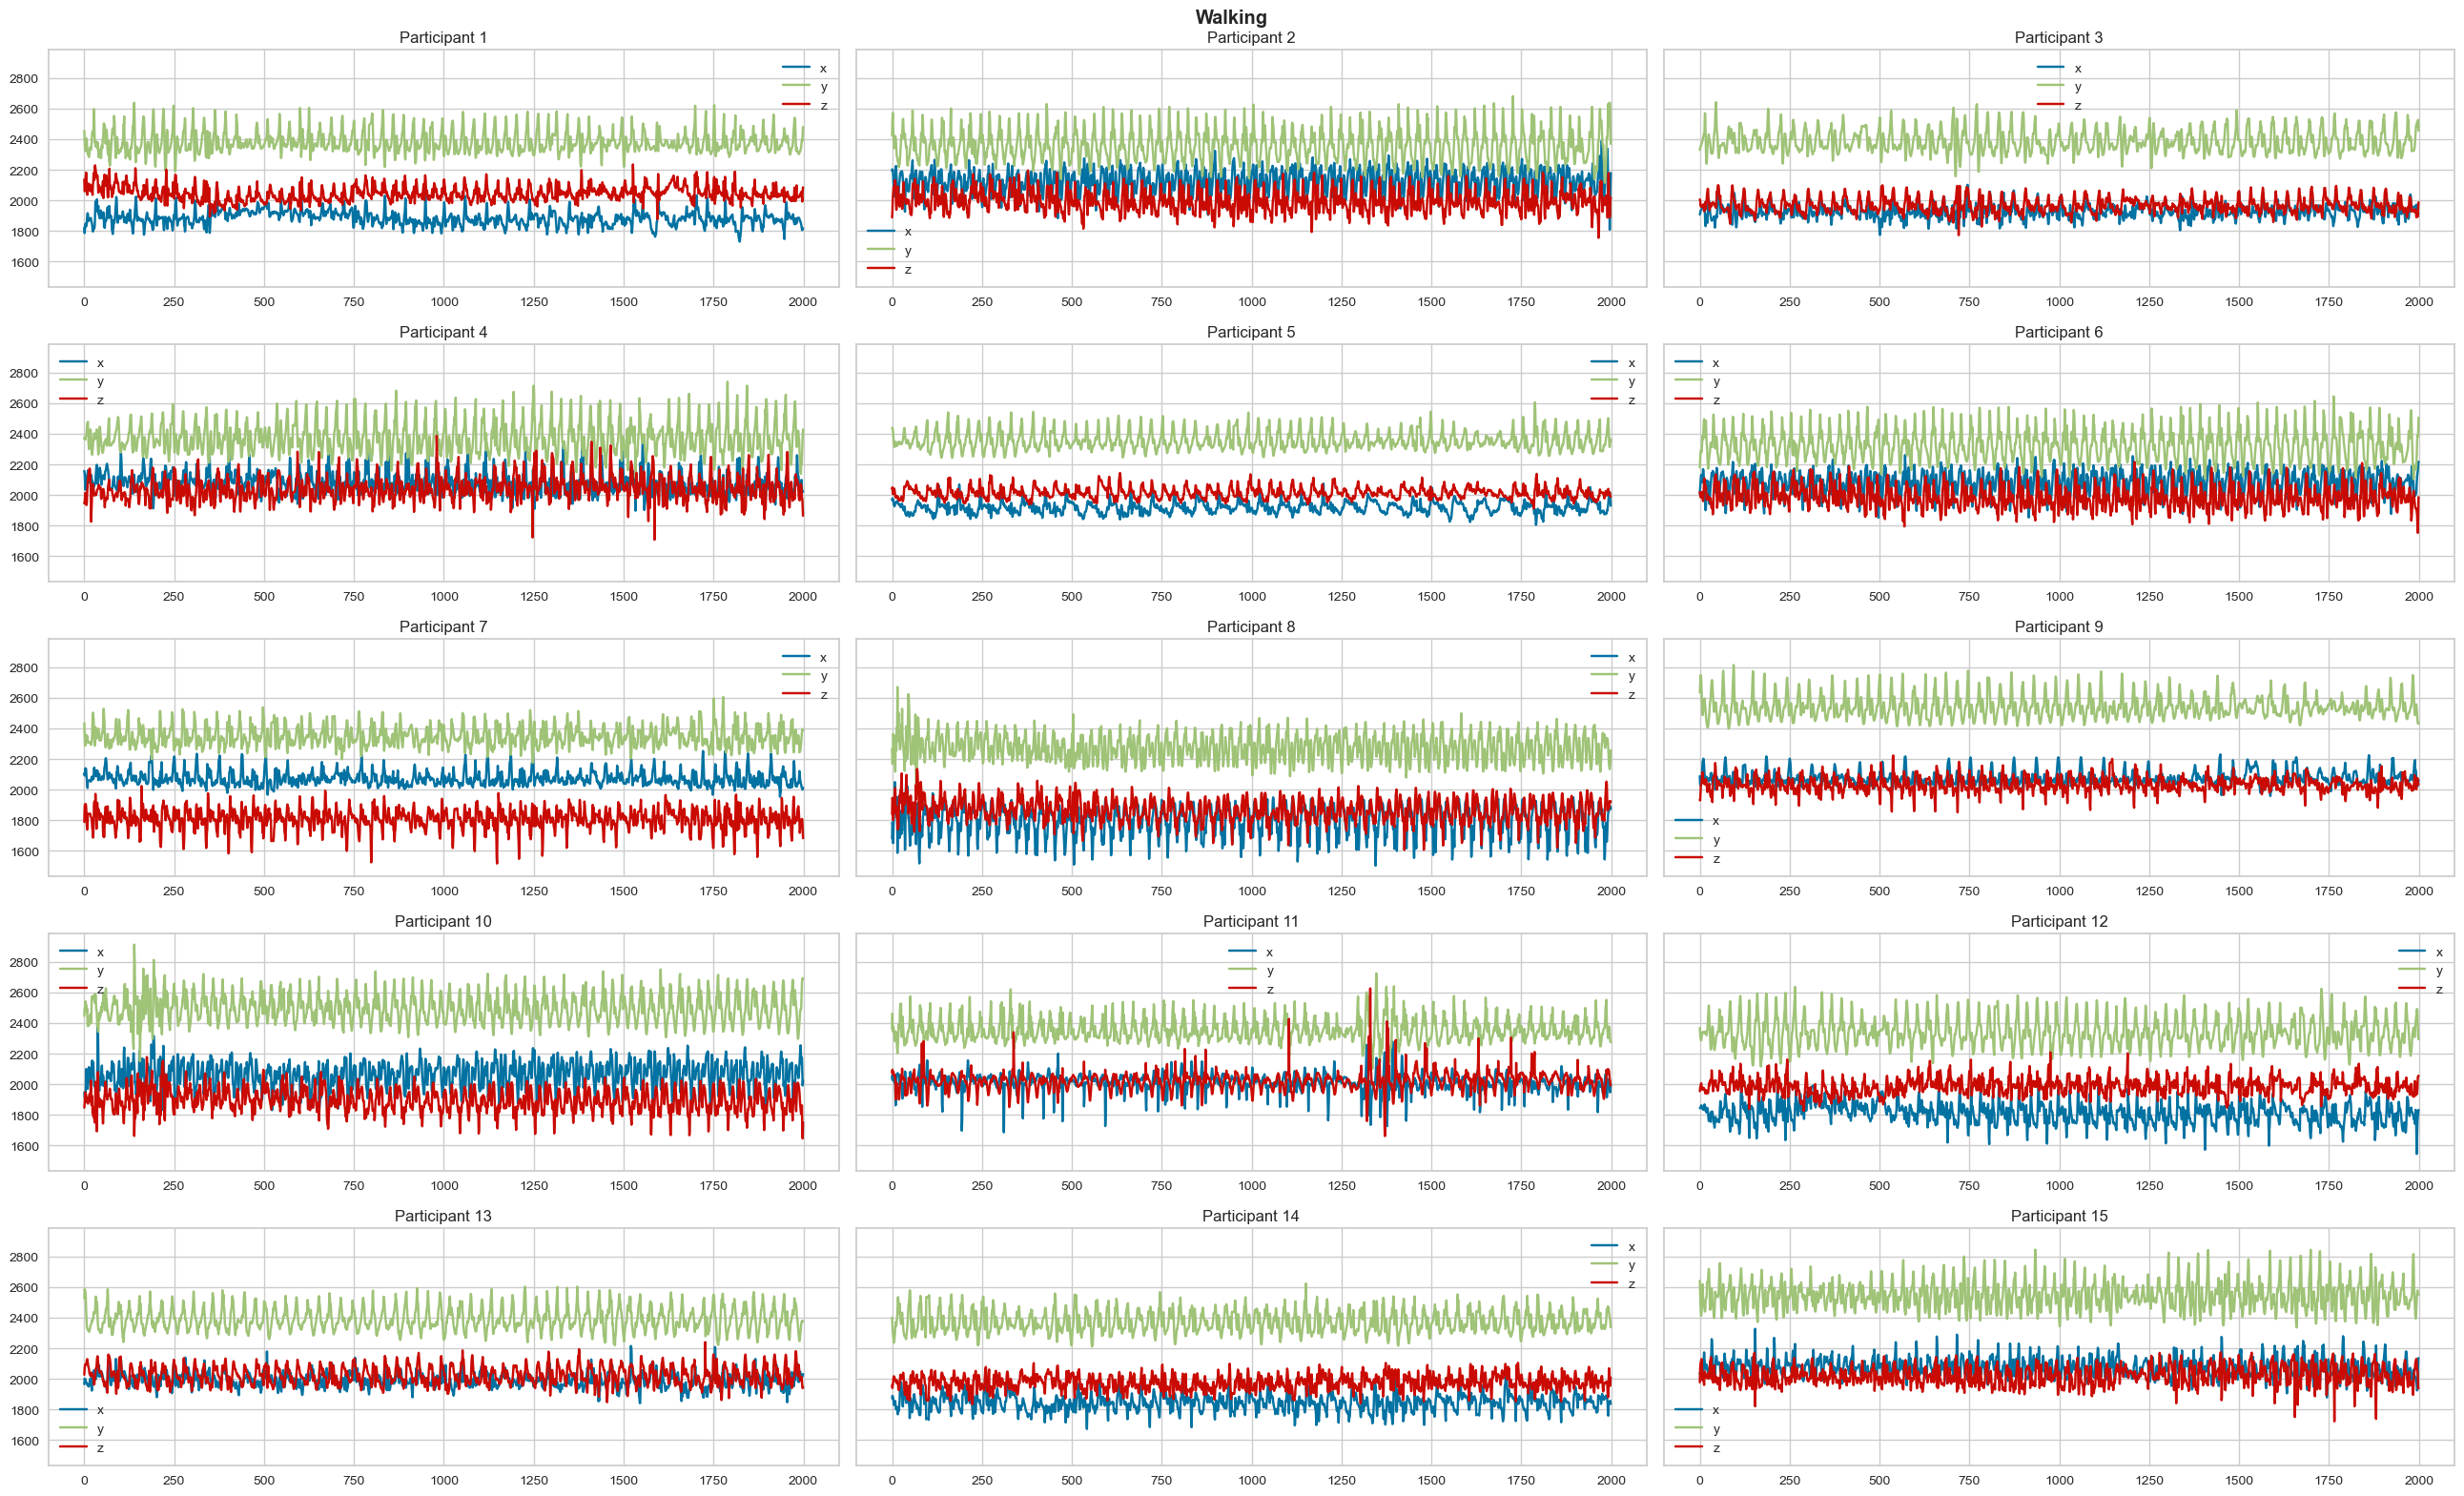

In [10]:
ncols = 3
nrows = 5
nsamples = 2000
fig, axs = plt.subplots(nrows, ncols, figsize=(26, 16), sharey=True)
for i in range(N_PARTICIPANTS):
    axs[int(i/ncols)][i%ncols].set_title(f"Participant {i+1}")
    participant_data = data[(data["participant"]==i+1)]
    axs[int(i/ncols)][i%ncols].plot(participant_data["time"][:nsamples], participant_data["x"][:nsamples], label="x")
    axs[int(i/ncols)][i%ncols].plot(participant_data["time"][:nsamples], participant_data["y"][:nsamples], label="y")
    axs[int(i/ncols)][i%ncols].plot(participant_data["time"][:nsamples], participant_data["z"][:nsamples], label="z")
    axs[int(i/ncols)][i%ncols].legend()
fig.suptitle(f"Walking", fontweight="bold")
plt.tight_layout()

Checking the number of samples per participant:

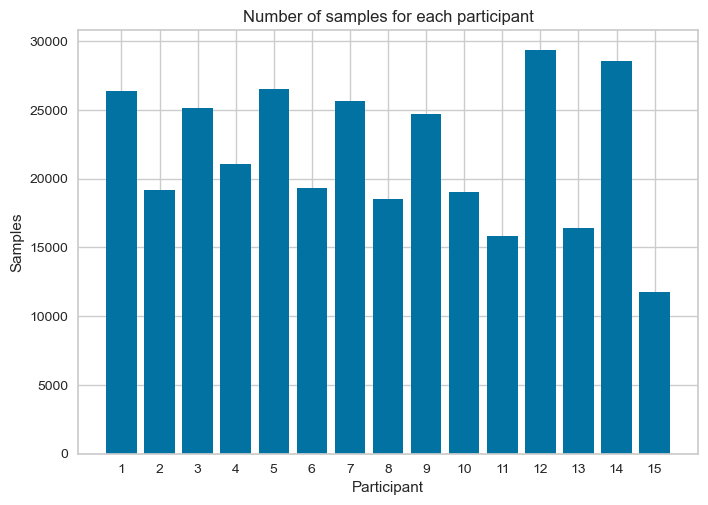

In [11]:
participant_count = data.groupby("participant").count()["time"]
plt.bar(participant_count.index, participant_count.values)
plt.xticks(np.arange(1, N_PARTICIPANTS+1));
plt.xlabel("Participant")
plt.ylabel("Samples")
plt.title("Number of samples for each participant");

## Feature extraction

### ARMA coefficients

We'll test three different models, i.e. (AR order = 3, MA order = 0), (AR order = 3, MA order = 1), (AR order = 5, MA order = 0), and select the best one using the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). Both AIC and BIC are penalized likelihood criteria (the lower the AIC and BIC, the better the model).

Higher orders were not explored to keep the number of features low.

In [12]:
params_list = [(3, 0, 0), (3, 0, 1), (5, 0, 0)]
res_df = pd.DataFrame()
for participant in range(1, N_PARTICIPANTS+1):
    participant_data = data[(data["participant"]==participant)]
    for dimension in ["x", "y", "z"]:
        series = participant_data[dimension].values
        for params in params_list:
            model = ARIMA(endog=series, order=params)
            res = model.fit()
            res_dict = {"participant": participant, "dimension": dimension, "params": params, "BIC": res.bic, "AIC": res.aic}
            res_df = pd.concat([res_df, pd.DataFrame([res_dict])])
res_df.reset_index(inplace=True)
res_df

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


index  participant dimension     params            BIC            AIC
0        0            1         x  (3, 0, 0)  240363.330358  240322.432343
1        0            1         x  (3, 0, 1)  240347.822959  240298.745341
2        0            1         x  (5, 0, 0)  240165.581113  240108.323892
3        0            1         y  (3, 0, 0)  256366.991395  256326.093380
4        0            1         y  (3, 0, 1)  256321.031874  256271.954256
..     ...          ...       ...        ...            ...            ...
130      0           15         y  (3, 0, 1)  120704.552772  120660.318016
131      0           15         y  (5, 0, 0)  120666.572278  120614.965063
132      0           15         z  (3, 0, 0)  123482.921704  123446.059408
133      0           15         z  (3, 0, 1)  123485.301922  123441.067167
134      0           15         z  (5, 0, 0)  123464.091885  123412.484670

[135 rows x 6 columns]

Plotting the results:

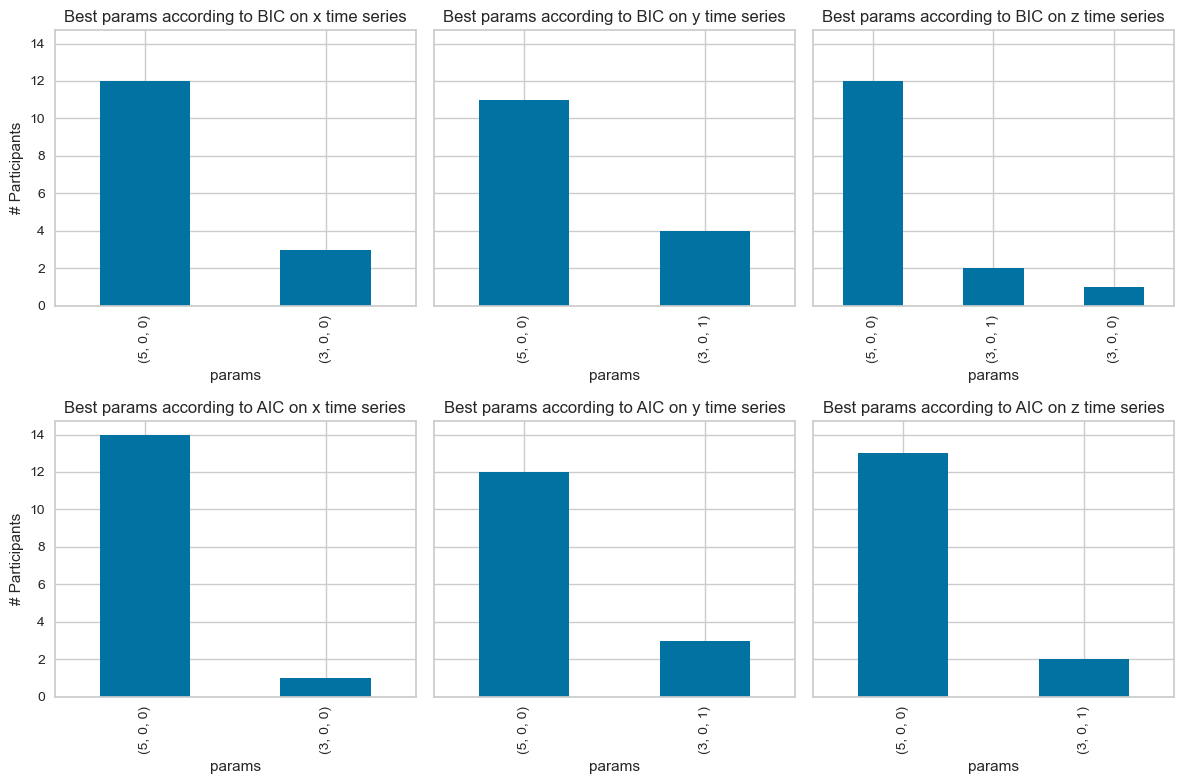

In [13]:
# get the best params for each participant and dimension according to BIC
best_bic_indices = res_df.groupby(['participant', 'dimension'])['BIC'].idxmin()
best_bic_params = res_df.loc[best_bic_indices, ['participant', 'dimension', 'params']]
# get the best params for each participant and dimension according to AIC
best_aic_indices = res_df.groupby(['participant', 'dimension'])['AIC'].idxmin()
best_aic_params = res_df.loc[best_aic_indices, ['participant', 'dimension', 'params']]

# plot the best params for each participant and dimension according to BIC and AIC
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
for i, dimension in enumerate(["x", "y", "z"]):
    best_bic_params[best_bic_params["dimension"]==dimension]["params"].value_counts().plot(
        kind="bar",
        title=f"Best params according to BIC on {dimension} time series",
        ax=axs[0][i],
        ylabel="# Participants"
    );
    best_aic_params[best_aic_params["dimension"]==dimension]["params"].value_counts().plot(
        kind="bar",
        title=f"Best params according to AIC on {dimension} time series",
        ax=axs[1][i],
        ylabel="# Participants"
    );
fig.tight_layout()

The configuration with an AR order of 5 and MA order of 0 consistently emerges as the optimal choice across all acceleration directions.

We proceed by fitting a model for each participant and acceleration direction, and with extracting the AR coefficients:

In [14]:
p = 5
coefs_df = pd.DataFrame()
for participant in range(1, N_PARTICIPANTS+1):
    participant_coefs = {}
    participant_data = data[(data["participant"]==participant)]
    for dimension in ["x", "y", "z"]:
        series = participant_data[dimension].values
        arima_res = ARIMA(endog=series, order=(p, 0, 0)).fit()
        for order in range(1, p+1):
            participant_coefs[f"{dimension}_alpha_{order}"] = arima_res.polynomial_ar[order]
    coefs_df = pd.concat([coefs_df, pd.DataFrame(participant_coefs, index=[participant])])
# scaling AR coefficients to [0, 1] for further analysis
coefs_scaled = MinMaxScaler().fit_transform(coefs_df)
coefs_scaled_df = pd.DataFrame(coefs_scaled, columns=coefs_df.columns)
coefs_df.describe()

x_alpha_1  x_alpha_2  x_alpha_3  x_alpha_4  x_alpha_5  y_alpha_1  \
count  15.000000  15.000000  15.000000  15.000000  15.000000  15.000000   
mean   -1.251747   0.531357  -0.058084  -0.040443   0.030905  -1.400952   
std     0.179409   0.198004   0.085210   0.071974   0.071057   0.156461   
min    -1.494792   0.229907  -0.213068  -0.220854  -0.071897  -1.608389   
25%    -1.412822   0.345408  -0.100011  -0.082619  -0.008839  -1.488481   
50%    -1.258820   0.562365  -0.036263  -0.028034   0.009903  -1.405012   
75%    -1.115408   0.683153  -0.014113   0.007502   0.056390  -1.344270   
max    -0.917943   0.866689   0.090353   0.087763   0.207450  -0.981676   

       y_alpha_2  y_alpha_3  y_alpha_4  y_alpha_5  z_alpha_1  z_alpha_2  \
count  15.000000  15.000000  15.000000  15.000000  15.000000  15.000000   
mean    0.585224  -0.042528  -0.049482   0.068531  -1.225634   0.574026   
std     0.249600   0.172828   0.110042   0.074233   0.223864   0.235602   
min     0.126928  -0.345995  -0.244105  -0.030304  -1.484614   0.011323   
25%     0.424681  -0.133565  -0.109895   0.007801  -1.375816   0.395304   
50%     0.591439  -0.028684  -0.048050   0.048988  -1.339119   0.647733   
75%     0.706197   0.094621  -0.005983   0.121917  -1.076552   0.683717   
max     1.031198   0.234951   0.210847   0.185918  -0.661890   1.019702   

       z_alpha_3  z_alpha_4  z_alpha_5  
count  15.000000  15.000000  15.000000  
mean   -0.158677   0.026906   0.022693  
std     0.088222   0.060754   0.048932  
min    -0.307099  -0.062938  -0.070482  
25%    -0.206119  -0.024414  -0.013784  
50%    -0.151303   0.035800   0.034836  
75%    -0.096081   0.044791   0.066032  
max    -0.049210   0.150530   0.079671

### Statistical features

In addition to the AR coefficients, we extract from each time series the following statistical features:
- Standard deviation
- Interquartile range
- Skewness
- Kurtosis

Features depending on the absolute values of the time series measurement are not considered, as they would be dependent on the measurement setup and not on the participant's movement.

In [15]:
def calculate_stats(series):
    features = {
        'std': np.std(series),
        'iqr': np.percentile(series, 75) - np.percentile(series, 25),
        'skw': sstats.skew(series),
        'kur': sstats.kurtosis(series)
    }
    return features

In [16]:
stats_df = pd.DataFrame()
for participant in range(1, N_PARTICIPANTS+1):
    participant_features = {}
    participant_data = data[(data["participant"]==participant)]
    for dimension in ["x", "y", "z"]:
        series = participant_data[dimension].values
        features = calculate_stats(series)
        features = {f'{dimension}_'+k : v for k, v in features.items()}
        participant_features.update(features)
    stats_df = pd.concat([stats_df, pd.DataFrame(participant_features, index=[participant])])
# scaling statistics to [0, 1] for further analysis
stats_scaled = MinMaxScaler().fit_transform(stats_df)
stats_scaled_df = pd.DataFrame(stats_scaled, columns=stats_df.columns)
stats_df.describe()

x_std       x_iqr      x_skw      x_kur       y_std       y_iqr  \
count  15.000000   15.000000  15.000000  15.000000   15.000000   15.000000   
mean   61.816784   79.200000   0.323771   1.198866   91.520233  125.766667   
std    15.498069   31.931176   0.558508   1.446380   13.036137   18.809778   
min    44.496764   42.000000  -0.485218  -0.623703   70.326608   91.000000   
25%    49.453027   57.500000  -0.043239   0.209626   81.687222  116.000000   
50%    58.046429   64.000000   0.247225   1.078402   88.822062  125.750000   
75%    71.797139   96.500000   0.633044   1.650553  100.711625  138.000000   
max    96.331963  156.000000   1.511668   4.218647  115.851040  153.000000   

           y_skw      y_kur      z_std       z_iqr      z_skw      z_kur  
count  15.000000  15.000000  15.000000   15.000000  15.000000  15.000000  
mean    0.388545  -0.222019  65.339204   81.633333   0.113312   1.315298  
std     0.235113   0.385939  12.415029   20.774698   0.502076   2.757462  
min     0.064100  -0.745725  44.886674   55.000000  -1.152856  -0.446073  
25%     0.257995  -0.462989  54.514725   65.500000  -0.114573   0.036392  
50%     0.349849  -0.304250  67.286090   78.000000   0.164185   0.256154  
75%     0.490640  -0.160740  75.250850   94.500000   0.456400   1.012780  
max     0.976002   0.662184  84.111291  119.000000   0.791597  10.598103

## Feature analysis

### Distribution

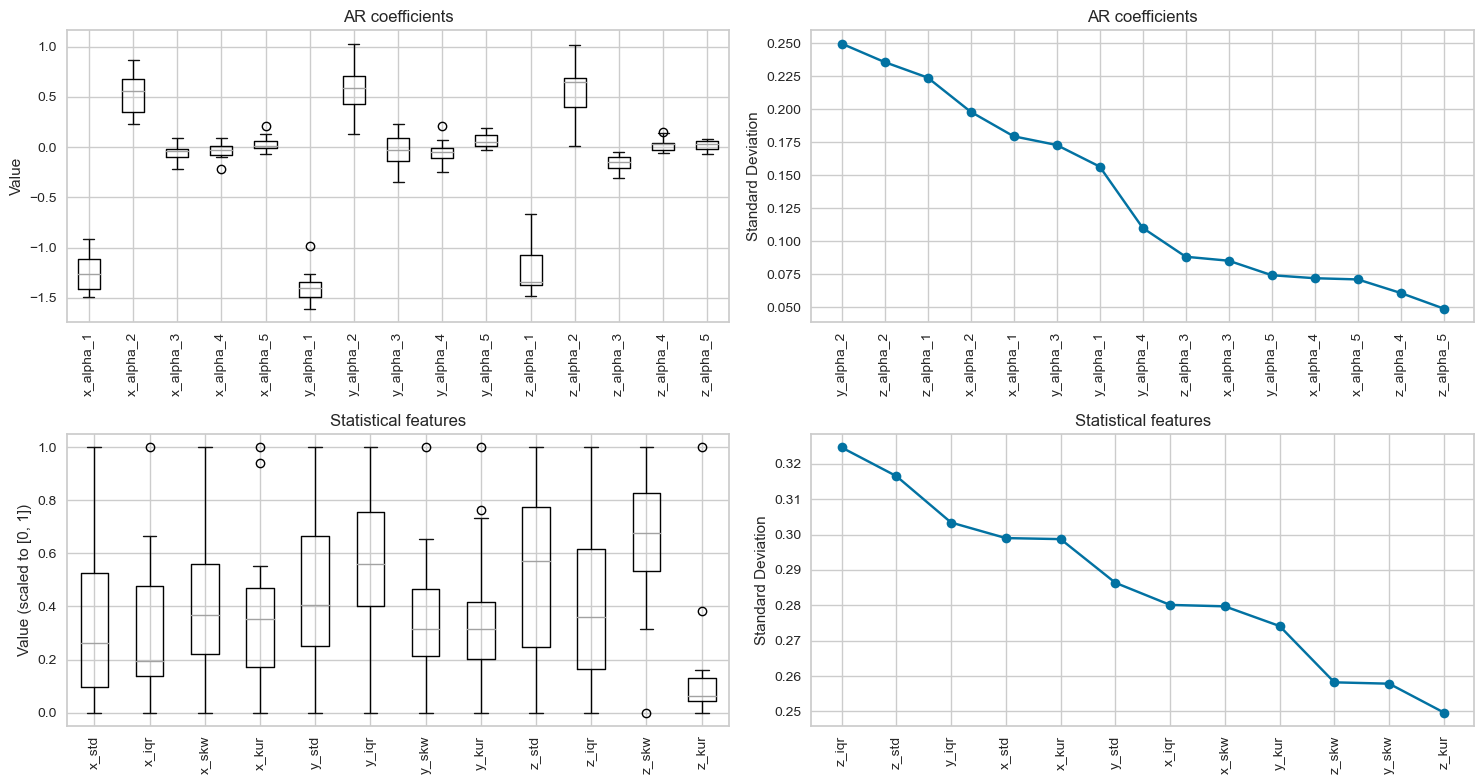

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
# plotting AR coefficients distribution
coefs_df.boxplot(rot=90, ax=axs[0][0])
axs[0][0].set_ylabel("Value")
axs[0][0].set_title("AR coefficients")
# plotting AR coefficients standard deviation
sorted_coefs = coefs_df.std().sort_values(ascending=False)
sorted_coefs.plot(marker='o', ax=axs[0][1])
axs[0][1].set_ylabel("Standard Deviation")
axs[0][1].set_xticks(range(0, sorted_coefs.size), sorted_coefs.index, rotation=90);
axs[0][1].set_title("AR coefficients")
# plotting statistics distribution
stats_scaled_df.boxplot(rot=90, ax=axs[1][0]);
axs[1][0].set_ylabel("Value (scaled to [0, 1])")
axs[1][0].set_title("Statistical features")
# plotting statistics standard deviation
sorted_stats = stats_scaled_df.std().sort_values(ascending=False)
sorted_stats.plot(marker='o', ax=axs[1][1])
axs[1][1].set_ylabel("Standard Deviation")
axs[1][1].set_xticks(range(0, sorted_stats.size), sorted_stats.index, rotation=90);
axs[1][1].set_title("Statistical features")
fig.tight_layout()

AR coefficients of lower order and the statistical features extracted from the time series measuring the acceleration along the z direction exhibit higher standard deviation, hence they should be more helpful in distinguishing between participants.

### Parallel coordinates plot

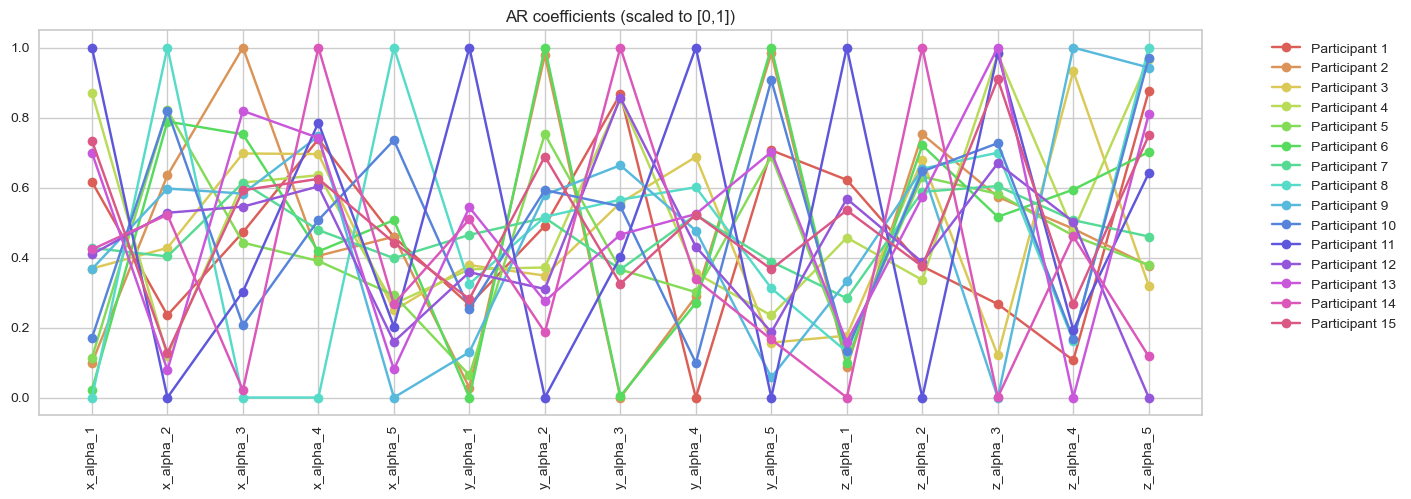

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
for i in range(N_PARTICIPANTS):
    plt.plot(coefs_scaled_df.iloc[i], marker='o', label=f"Participant {i+1}", c=sns.color_palette("hls", N_PARTICIPANTS)[i])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(coefs_scaled_df.columns)), coefs_scaled_df.columns, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title("AR coefficients (scaled to [0,1])");

The parallel coordinates plot of the AR coefficients reveals the following insights:
- participants 2 and 6 exhibit similar values in the coefficients of y and z acceleration
- the coefficients of participants 8, 11 and 14 are often far away from the others
- it is not clear whether participants can be effectively clustered based on the AR coefficients

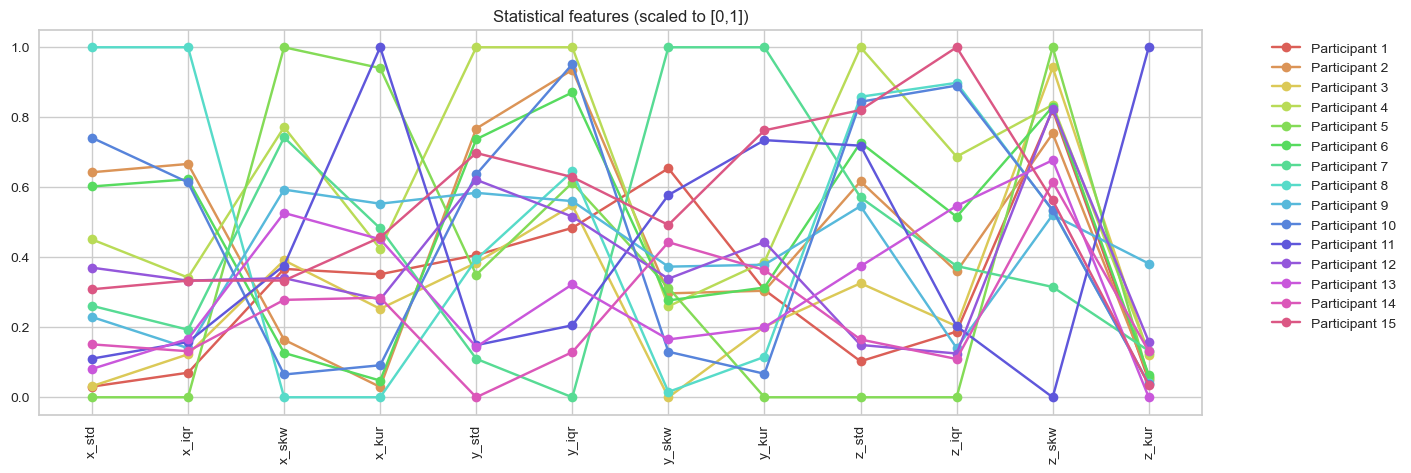

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
for i in range(N_PARTICIPANTS):
    plt.plot(stats_scaled_df.iloc[i], marker='o', label=f"Participant {i+1}", c=sns.color_palette("hls", N_PARTICIPANTS)[i])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(stats_scaled_df.columns)), stats_scaled_df.columns, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
plt.title("Statistical features (scaled to [0,1])");

The parallel coordinates plot of the statistical features shows that:
- participants 2 and 6 exhibit similar values on the features extracted from the x and y acceleration
- participant 11 differs from the others in skewness and kurtosis of the z acceleration, while participant 7 differs in skewness and kurtosis of the y acceleration

### Dimensionality reduction

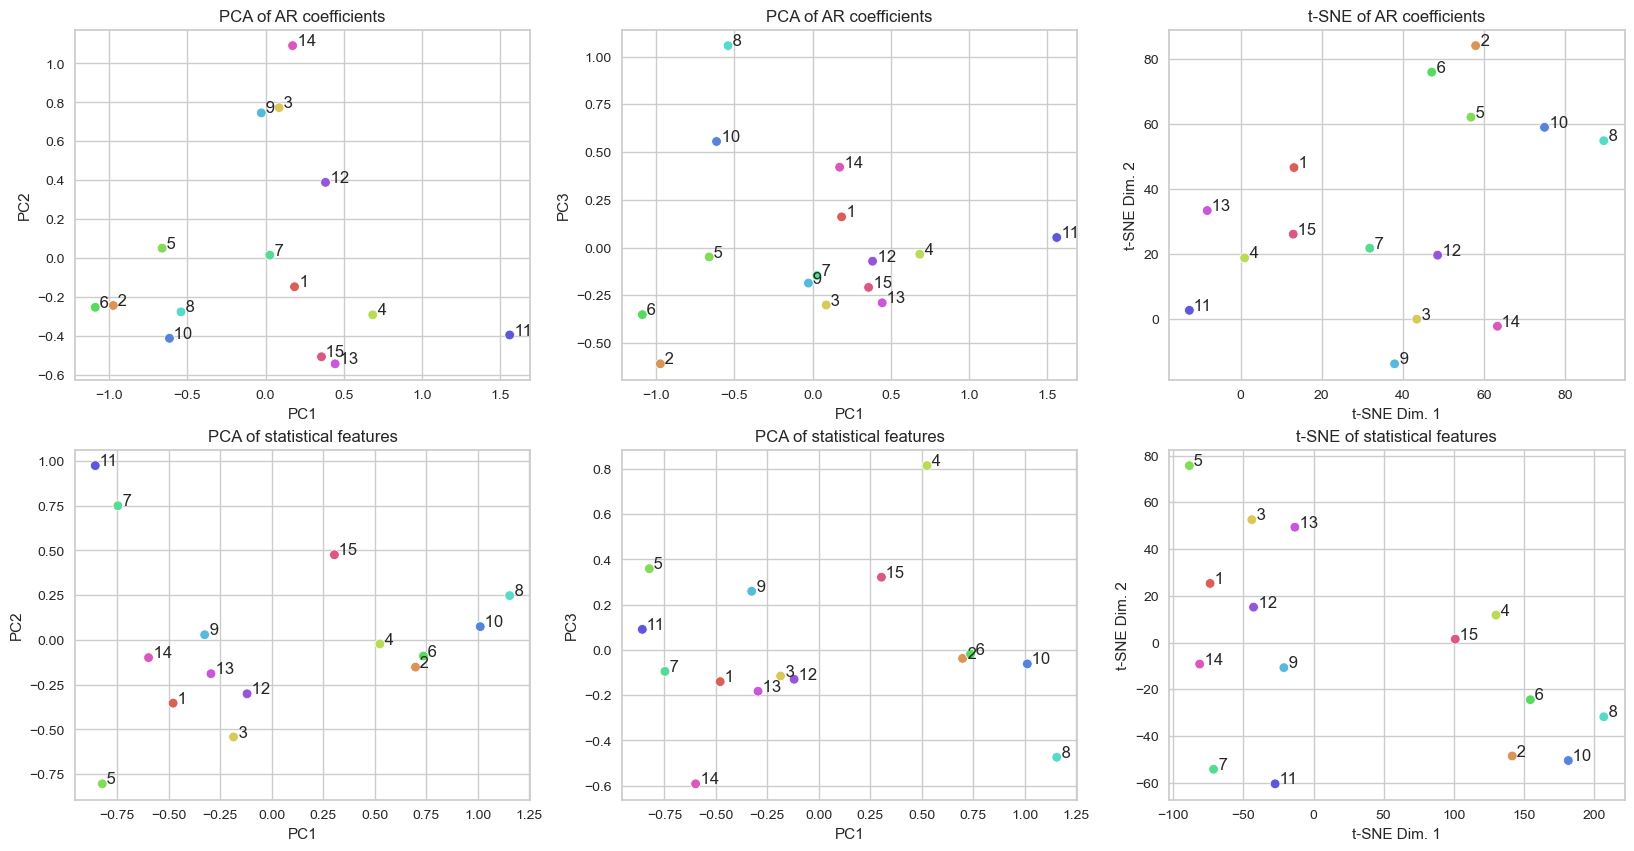

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
# ---- AR COEFFICIENTS ----
# computing PCA of AR coefficients
pca = PCA(n_components = 3)
coefs_PC = pca.fit_transform(coefs_scaled_df)
# 2D plot of the first and second principal components of AR coefficients
sns.scatterplot(x=coefs_PC[:, 0], y=coefs_PC[:, 1], hue=coefs_df.index, palette=sns.color_palette("hls", N_PARTICIPANTS), ax=axs[0][0])
for i in range(N_PARTICIPANTS):
    axs[0][0].text(coefs_PC[i, 0], coefs_PC[i, 1], f" {i+1}")
axs[0][0].set_xlabel("PC1")
axs[0][0].set_ylabel("PC2")
axs[0][0].get_legend().remove()
axs[0][0].set_title("PCA of AR coefficients");
# 2D plot of the first and third principal components of AR coefficients
sns.scatterplot(x=coefs_PC[:, 0], y=coefs_PC[:, 2], hue=coefs_df.index, palette=sns.color_palette("hls", N_PARTICIPANTS), ax=axs[0][1])
for i in range(N_PARTICIPANTS):
    axs[0][1].text(coefs_PC[i, 0], coefs_PC[i, 2], f" {i+1}")
axs[0][1].set_xlabel("PC1")
axs[0][1].set_ylabel("PC3")
axs[0][1].get_legend().remove()
axs[0][1].set_title("PCA of AR coefficients");
# computing t-SNE of AR coefficients
tsne = TSNE(n_components=2, perplexity=5, random_state=RANDOM_STATE)
coefs_tnse = tsne.fit_transform(coefs_scaled_df)
sns.scatterplot(x=coefs_tnse[:, 0], y=coefs_tnse[:, 1], hue=coefs_scaled_df.index, palette=sns.color_palette("hls", N_PARTICIPANTS), ax=axs[0][2])
for i in range(N_PARTICIPANTS):
    axs[0][2].text(coefs_tnse[i, 0], coefs_tnse[i, 1], f" {i+1}")
axs[0][2].set_xlabel("t-SNE Dim. 1")
axs[0][2].set_ylabel("t-SNE Dim. 2")
axs[0][2].get_legend().remove()
axs[0][2].set_title("t-SNE of AR coefficients");
# ---- STATISTICAL FEATURES ----
# computing PCA of statistical features
stats_PC = pca.fit_transform(stats_scaled_df)
# 2D plot of the first and second principal components of statistical features
sns.scatterplot(x=stats_PC[:, 0], y=stats_PC[:, 1], hue=stats_df.index, palette=sns.color_palette("hls", N_PARTICIPANTS), ax=axs[1][0])
for i in range(N_PARTICIPANTS):
    axs[1][0].text(stats_PC[i, 0], stats_PC[i, 1], f" {i+1}")
axs[1][0].set_xlabel("PC1")
axs[1][0].set_ylabel("PC2")
axs[1][0].get_legend().remove()
axs[1][0].set_title("PCA of statistical features");
# 2D plot of the first and third principal components of statistical features
sns.scatterplot(x=stats_PC[:, 0], y=stats_PC[:, 2], hue=stats_df.index, palette=sns.color_palette("hls", N_PARTICIPANTS), ax=axs[1][1])
for i in range(N_PARTICIPANTS):
    axs[1][1].text(stats_PC[i, 0], stats_PC[i, 2], f" {i+1}")
axs[1][1].set_xlabel("PC1")
axs[1][1].set_ylabel("PC3")
axs[1][1].get_legend().remove()
axs[1][1].set_title("PCA of statistical features");
# computing TSNE of statistical features
stats_tnse = tsne.fit_transform(stats_scaled_df)
sns.scatterplot(x=stats_tnse[:, 0], y=stats_tnse[:, 1], hue=stats_scaled_df.index, palette=sns.color_palette("hls", N_PARTICIPANTS), ax=axs[1][2])
for i in range(N_PARTICIPANTS):
    axs[1][2].text(stats_tnse[i, 0], stats_tnse[i, 1], f" {i+1}")
axs[1][2].set_xlabel("t-SNE Dim. 1")
axs[1][2].set_ylabel("t-SNE Dim. 2")
axs[1][2].get_legend().remove()
axs[1][2].set_title("t-SNE of statistical features");

We observe that:
- participants 2 and 6, as well as participants 8 and 10, cluster together both in the PCA and t-SNE space of the AR coefficients and the statistical features
- participant 13 and 15 cluster together in the PCA space of the AR coefficients, but not in the PCA space of the statistical features
- participant 11 is isolated in the space of the AR coefficients, but not in the space of the statistical features

These results suggest that the AR coefficients and the statistical features capture different aspects of the participants' movement.

## Participant clustering

Given the challenge of identifying participant groups due to the extensive number of features, we will employ a clustering algorithm, using both the AR coefficients and statistical features as input variables.

We will utilize the KMeans algorithm with the Euclidean distance metric, exploring a range of clusters from 2 to 14 (N_PARTICIPANTS-1). To determine the optimal number of clusters, we will evaluate both the [Silhouette score](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) (a metric ranging from -1 to 1 that assesses the cohesion and separation of clusters) and the implementation of the [Yellowbrick](https://www.scikit-yb.org/en/latest/index.html) library of the "Elbow method" on the Sum of Squared distances to the centroids (SSE). Please note that the clustering will be performed on features scaled to a range of [0-1] to prevent any single feature from dominating others.

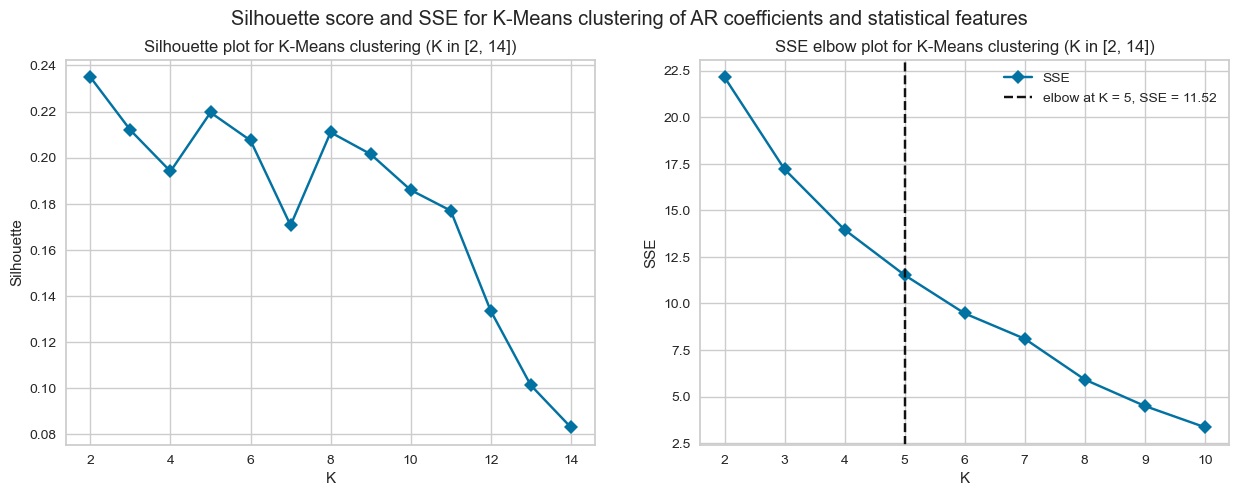

In [21]:
# concatenating AR coefficients and statistical features
features_df = pd.concat([coefs_df, stats_df], axis=1)
# scaling features to [0, 1]
features_scaled = MinMaxScaler().fit_transform(features_df)
features_scaled_df = pd.DataFrame(features_scaled, columns=features_df.columns)
# defining K-Means settings
min_k = 2
max_k = N_PARTICIPANTS-1
kmeans = KMeans(n_init=10, random_state=RANDOM_STATE)
# plotting silhouette plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
elbow_sil = KElbowVisualizer(kmeans, k=(min_k, max_k+1), timings=False, metric="silhouette", locate_elbow=False, ax=axs[0])
elbow_sil.fit(features_scaled)
axs[0].set_title(f'Silhouette plot for K-Means clustering (K in [{str(min_k)}, {str(max_k)}])')
axs[0].set_ylabel("Silhouette")
axs[0].set_xlabel('K');
# plotting SSE elbow plot
elbow_sse = KElbowVisualizer(kmeans, timings=False, metric="distortion", locate_elbow=True, ax=axs[1])
elbow_sse.fit(features_scaled)
axs[1].set_title(f'SSE elbow plot for K-Means clustering (K in [{str(min_k)}, {str(max_k)}])')
axs[1].set_ylabel("SSE")
axs[1].set_xlabel('K');
axs[1].legend([
    f'SSE',
    f'elbow at K = {str(elbow_sse.elbow_value_)}, SSE = {elbow_sse.elbow_score_:0.2f}'
]);
fig.suptitle("Silhouette score and SSE for K-Means clustering of AR coefficients and statistical features");

The highest silhouette score is achieved with 2 clusters, followed by 5 clusters. The Elbow method suggests that the optimal number of clusters is 5. We will opt for a finer granularity and select 5 clusters:

In [22]:
nclusters = 5
kmeans = KMeans(n_init=10, n_clusters=nclusters, random_state=RANDOM_STATE)
kmeans.fit(features_scaled)
labels = kmeans.labels_

Plotting the clusters in the PCA space and in the t-NSE space:

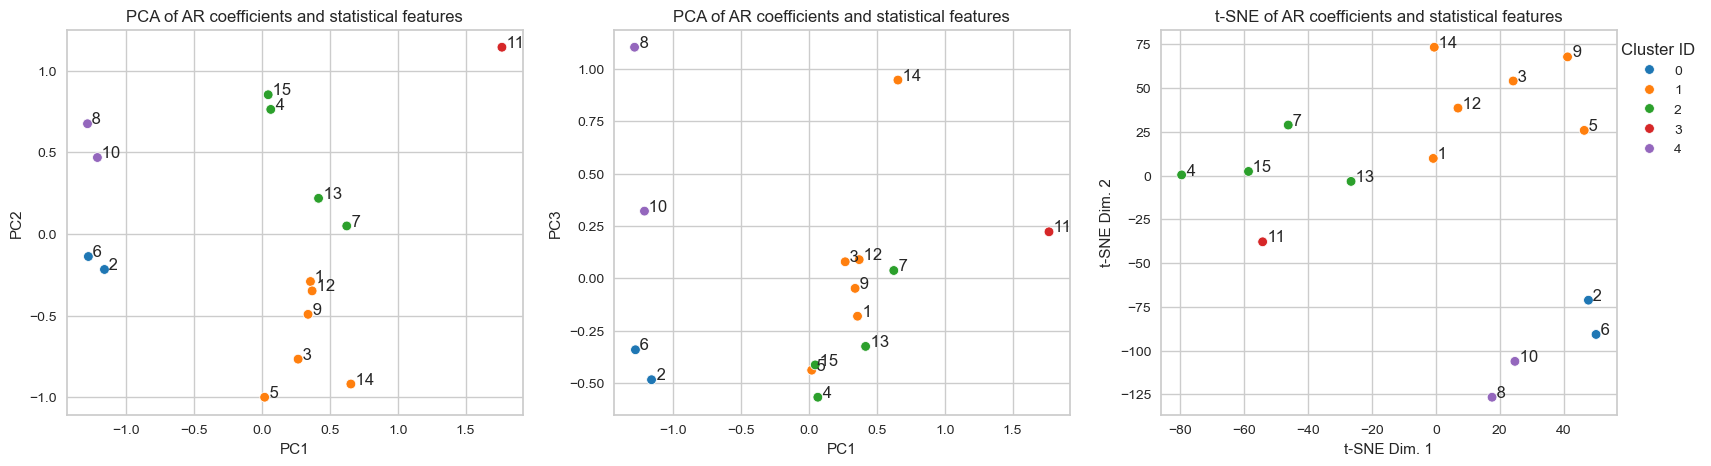

In [23]:
# computing PCA
features_PC = pca.fit_transform(features_scaled_df)
# plotting the first 3 principal components 
fig, axs = plt.subplots(1, 3,figsize=(20,5))
# 2D plot of the first and second principal components
sns.scatterplot(x=features_PC[:, 0], y=features_PC[:, 1], hue=labels, palette=sns.color_palette("tab10")[:nclusters], ax=axs[0])
# plotting participants
for i in range(N_PARTICIPANTS):
    axs[0].text(features_PC[i, 0], features_PC[i, 1], f" {i+1}")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].get_legend().remove()
axs[0].set_title("PCA of AR coefficients and statistical features");
# 2D plot of the first and third principal components
sns.scatterplot(x=features_PC[:, 0], y=features_PC[:, 2], hue=labels, palette=sns.color_palette("tab10")[:nclusters], ax=axs[1])
for i in range(N_PARTICIPANTS):
    axs[1].text(features_PC[i, 0], features_PC[i, 2], f" {i+1}")
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC3")
axs[1].set_title("PCA of AR coefficients and statistical features");
axs[1].get_legend().remove()
# computing t-SNE
features_tnse = tsne.fit_transform(features_scaled_df)
# plotting t-SNE
sns.scatterplot(x=features_tnse[:, 0], y=features_tnse[:, 1], hue=labels, palette=sns.color_palette("tab10")[:nclusters], ax=axs[2])
for i in range(N_PARTICIPANTS):
    axs[2].text(features_tnse[i, 0], features_tnse[i, 1], f" {i+1}")
axs[2].set_xlabel("t-SNE Dim. 1")
axs[2].set_ylabel("t-SNE Dim. 2")
axs[2].set_title("t-SNE of AR coefficients and statistical features");
# set legend
handles, _ = axs[2].get_legend_handles_labels()
axs[2].legend(handles=handles, labels=[f'{i}' for i in range(nclusters)], title="Cluster ID", loc="upper right", bbox_to_anchor=(1.2, 1));

From the clustering, we observe that:
- despite the low silhouette score, points in the reduced space are well separated
- participants 2 and 6, as well as participants 8 and 10 belong to the same cluster, confirming previous observations
- participant 11 belongs to a cluster of its own, confirming again previous observations
- the other participants are distributed across two clusters

Visualizing the clusters centroids:

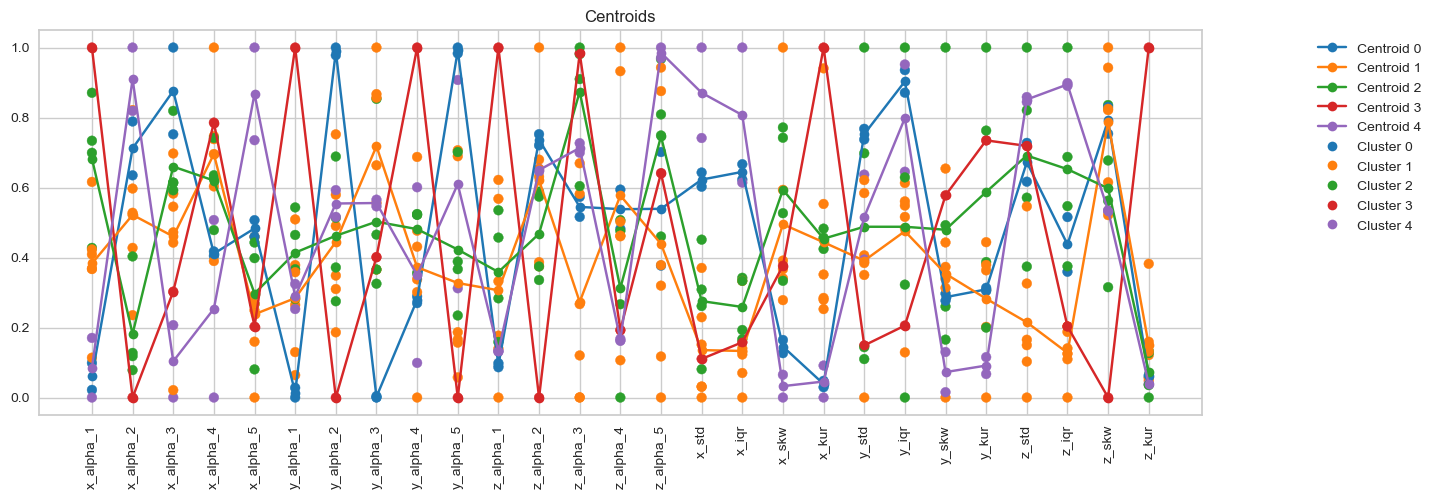

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
legend_elements = []
for i in range(0, len(kmeans.cluster_centers_)):
    plt.plot(kmeans.cluster_centers_[i], marker='o', label=f'Centroid {i}', c=sns.color_palette('tab10')[i])
    legend_elements.append(Line2D([], [], marker='o', color='w', label=f'Cluster {i}', markerfacecolor=sns.color_palette("tab10")[i]))
features_scaled_df["cluster"] = labels
for i in range(N_PARTICIPANTS):
    cluster = int(features_scaled_df.iloc[i]["cluster"])
    color = sns.color_palette("tab10")[cluster]
    plt.scatter(np.arange(0, len(features_scaled_df.columns)-1), features_scaled_df.iloc[i][:-1], marker='o', c=[color for _ in np.arange(len(features_scaled_df.columns)-1)])
plt.tick_params(axis='both', which='major', labelsize=10)
features_scaled_df.drop(columns=["cluster"], inplace=True)
plt.xticks(range(0, len(features_scaled_df.columns)), features_scaled_df.columns, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
handles, _ = axs.get_legend_handles_labels()
plt.legend(handles=handles+legend_elements, loc="upper right", bbox_to_anchor=(1.2, 1))
plt.title(f'Centroids');

We observe that:
- Cluster 0 (containing participants 2 and 6) differs from the others in the AR coefficients of the y acceleration
- Cluster 3 (containing participants 11) differs from the others in several features
- Cluster 4 (containing participants 8 and 10) differs from the others in the AR coefficients of the x acceleration and in some statistical features along all acceleration directions

We'll now use Ward's hierarchical clustering with the euclidean distance as metric, to get insight into the hierarchical structure of the clusters:

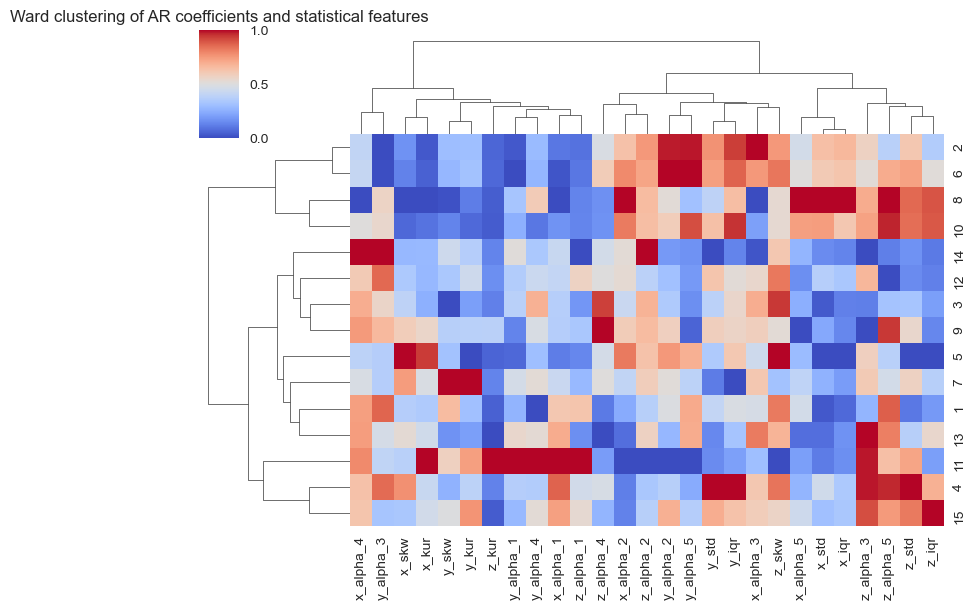

In [25]:
features_scaled_df.index += 1
sns.clustermap(features_scaled_df, method='ward', cmap='coolwarm', metric='euclidean', figsize=(8, 6))
plt.title('Ward clustering of AR coefficients and statistical features', loc="center");

The hierarchical clustering partially confirms the results obtained with KMeans:
- participants 2 and 6 are in the same cluster as well as participants 8 and 10, as in the KMeans clustering
- participant 11 is isolated in a cluster of its own, later joined by participant 15 and 4
- however, the other participants split into clusters in a different way

## Clustering Time Series Windows

The features extracted from the whole time series may not be representative of the participant's movement as they are computed over long time periods. To explore the similarities and differences among participants in greater detail, we will split each time series into windows, extract features from each window, and then cluster the windows.

We will use widows of 208 samples (corresponding to 4 seconds), with a 50% overlap.

In [26]:
WINDOW_SIZE = SAMPLING_FREQUENCY*4
STEP = int(WINDOW_SIZE/2)

For example, in the plot below, each vertical dashed line denotes the beginning of a new window within the initial segment of participant 1's time series:

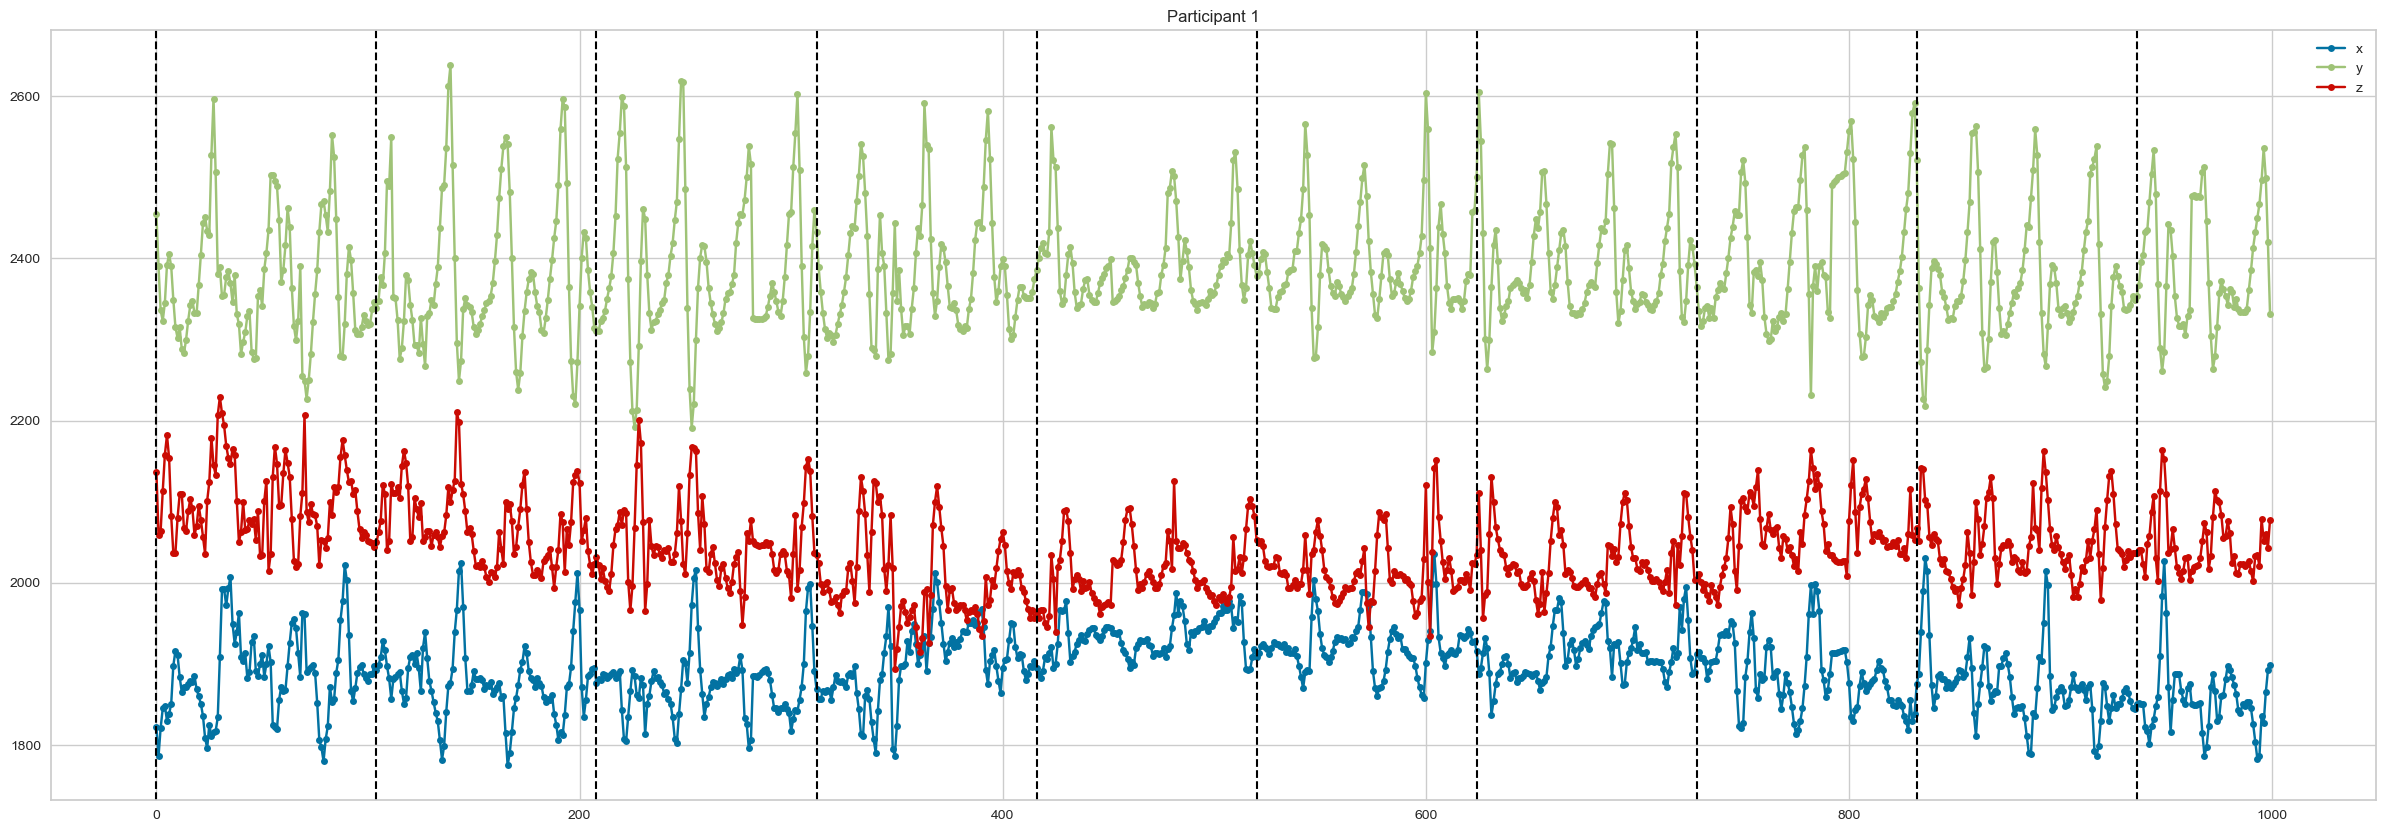

In [27]:
participant = 1
max_time = 1000
fig, axs = plt.subplots(1, figsize=(30, 10), sharex=True, sharey=True)
for dimension in ["x", "y", "z"]:
    axs.plot(
        data[(data["participant"]==participant)]["time"][:max_time],
        data[(data["participant"]==participant)][dimension][:max_time],
        '-o',
        markersize=5,
        label=dimension
    )
for i in range(0, max_time, STEP):
    axs.axvline(x=i, color='black', linestyle='--', linewidth=1.5)
axs.set_title(f"Participant {participant}")
axs.legend()

We proceed with extracting the features from the windows:

In [28]:
window_features_df = pd.DataFrame()
for participant in range(1, N_PARTICIPANTS+1):
    participant_data = data[(data["participant"]==participant)]
    for window_num, i in enumerate(range(0, participant_data.shape[0], STEP)):
        window_features = {"participant": participant, "window_num": window_num}
        for dimension in ["x", "y", "z"]:
            series = participant_data[dimension].values
            window = series[i:i+WINDOW_SIZE]
            if window.size != WINDOW_SIZE:
                continue
            # compute AR coefficients
            arima_res = ARIMA(endog=window, order=(p, 0, 0)).fit()
            for order in range(1, p+1):
                window_features[f"{dimension}_alpha_{order}"] = arima_res.polynomial_ar[order]
            # compute statistical features
            stats = calculate_stats(window)
            stats = {f'{dimension}_'+k: v for k, v in stats.items()}
            window_features.update(stats)
        if len(window_features) != 2: # features were actually computed
            window_features_df = pd.concat([window_features_df, pd.DataFrame([window_features])])
# scaling features to [0, 1] for further analysis
window_features_scaled = MinMaxScaler().fit_transform(window_features_df.drop(columns=['participant', 'window_num']))
window_features_scaled_df = pd.DataFrame(window_features_scaled, columns=window_features_df.columns.drop(['participant', 'window_num']))
window_features_df.describe()

participant   window_num    x_alpha_1    x_alpha_2    x_alpha_3  \
count  3128.000000  3128.000000  3128.000000  3128.000000  3128.000000   
mean      7.726023   109.318414    -1.265419     0.564411    -0.078138   
std       4.278601    68.638723     0.204037     0.255672     0.174825   
min       1.000000     0.000000    -1.800799    -0.262585    -0.684439   
25%       4.000000    52.000000    -1.415652     0.387606    -0.190194   
50%       8.000000   104.000000    -1.276356     0.563570    -0.066237   
75%      12.000000   160.000000    -1.142409     0.741911     0.039496   
max      15.000000   280.000000    -0.514625     1.415516     0.468507   

         x_alpha_4    x_alpha_5        x_std        x_iqr        x_skw  ...  \
count  3128.000000  3128.000000  3128.000000  3128.000000  3128.000000  ...   
mean     -0.023343     0.034105    58.392280    73.860534     0.338969  ...   
std       0.141605     0.096329    17.010294    33.991729     0.681896  ...   
min      -0.591824    -0.218960    25.951857    26.250000    -3.069826  ...   
25%      -0.108258    -0.032897    45.665642    49.250000    -0.147159  ...   
50%      -0.012756     0.028456    54.982577    63.250000     0.235329  ...   
75%       0.070087     0.093174    68.288572    87.562500     0.778982  ...   
max       0.418625     0.386846   116.295214   202.250000     3.575318  ...   

             y_kur    z_alpha_1    z_alpha_2    z_alpha_3    z_alpha_4  \
count  3128.000000  3128.000000  3128.000000  3128.000000  3128.000000   
mean     -0.359499    -1.250999     0.626092    -0.189153     0.043588   
std       0.578707     0.237490     0.291854     0.188494     0.140125   
min      -1.374156    -1.763621    -0.344055    -0.868457    -0.431504   
25%      -0.740212    -1.427763     0.437327    -0.309526    -0.047443   
50%      -0.471388    -1.301514     0.628185    -0.168415     0.036244   
75%      -0.108034    -1.101278     0.819803    -0.054767     0.134162   
max       4.018614    -0.433185     1.559211     0.452849     0.538423   

         z_alpha_5        z_std        z_iqr        z_skw        z_kur  
count  3128.000000  3128.000000  3128.000000  3128.000000  3128.000000  
mean      0.023723    61.075050    76.267983     0.190487     0.699911  
std       0.086555    15.227891    22.756573     0.602521     2.572472  
min      -0.296964    24.950632    30.250000    -6.691576    -1.281680  
25%      -0.034781    48.032771    59.000000    -0.099181    -0.201488  
50%       0.025300    60.050885    71.000000     0.288664     0.218042  
75%       0.082360    73.164511    89.500000     0.560232     0.751245  
max       0.340354   115.559767   166.500000     3.127032    70.482515  

[8 rows x 29 columns]

Plotting features distribution for each participant:

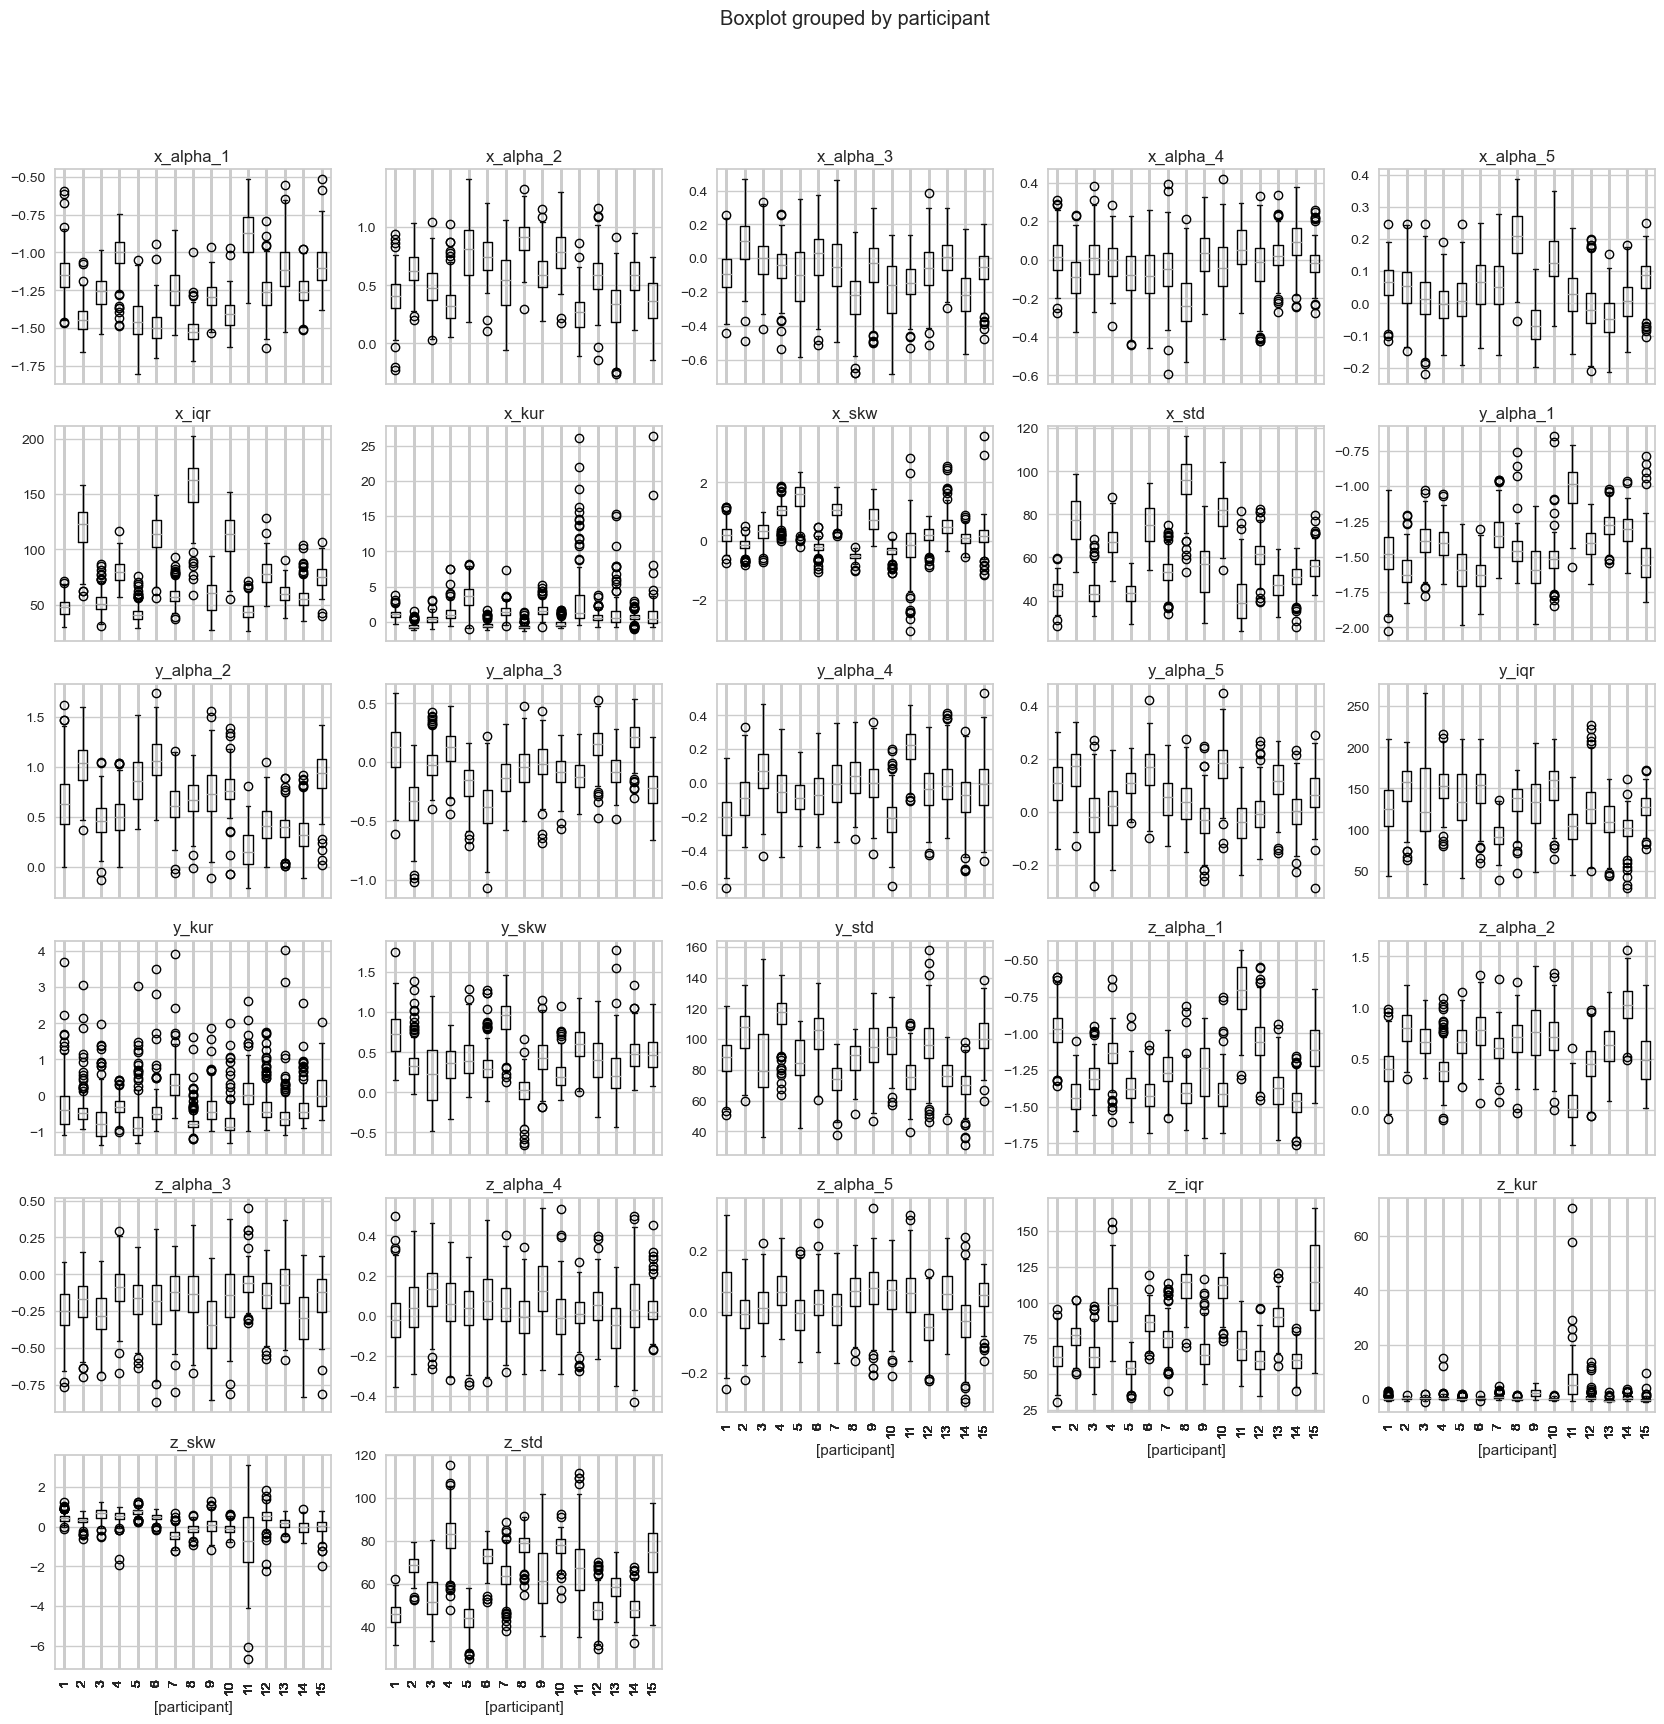

In [29]:
window_features_df.drop(columns=['window_num']).boxplot(rot=90, by='participant', figsize=(20, 20), sharey=False);

It is evident that the values of the features in different windows from the same participant vary, suggesting that movement patterns change over time.

Clustering windows with KMeans, testing the number of clusters from 2 to N_PARTICIPANTS*2:

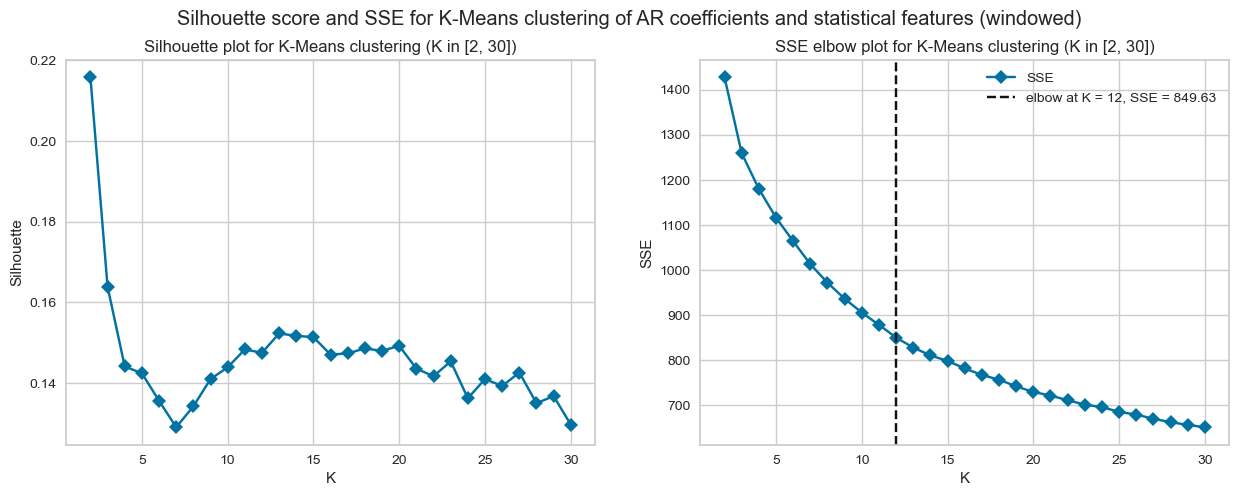

In [30]:
min_k = 2
max_k = N_PARTICIPANTS*2

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
elbow_sil = KElbowVisualizer(kmeans, k=(min_k, max_k+1), timings=False, metric="silhouette", locate_elbow=False, ax=axs[0])
elbow_sil.fit(window_features_scaled)
axs[0].set_title(f'Silhouette plot for K-Means clustering (K in [{str(min_k)}, {str(max_k)}])')
axs[0].set_ylabel("Silhouette")
axs[0].set_xlabel('K');

elbow_sse = KElbowVisualizer(kmeans, k=(min_k, max_k+1), timings=False, metric="distortion", locate_elbow=True, ax=axs[1])
elbow_sse.fit(window_features_scaled)
axs[1].set_title(f'SSE elbow plot for K-Means clustering (K in [{str(min_k)}, {str(max_k)}])')
axs[1].set_ylabel("SSE")
axs[1].set_xlabel('K');
axs[1].legend([
    f'SSE',
    f'elbow at K = {str(elbow_sse.elbow_value_)}, SSE = {elbow_sse.elbow_score_:0.2f}'
]);
fig.suptitle("Silhouette score and SSE for K-Means clustering of AR coefficients and statistical features (windowed)");

The silhouette score suggests that the best number of clusters is 2. For higher number of clusters, the silhouette score drops significantly.

Clustering windows with 2 clusters:

In [31]:
nclusters_window = 2
kmeans_window = KMeans(n_init=10, n_clusters=nclusters_window, random_state=RANDOM_STATE)
kmeans_window.fit(window_features_scaled)
labels_window = kmeans_window.labels_

Plotting clusters size:

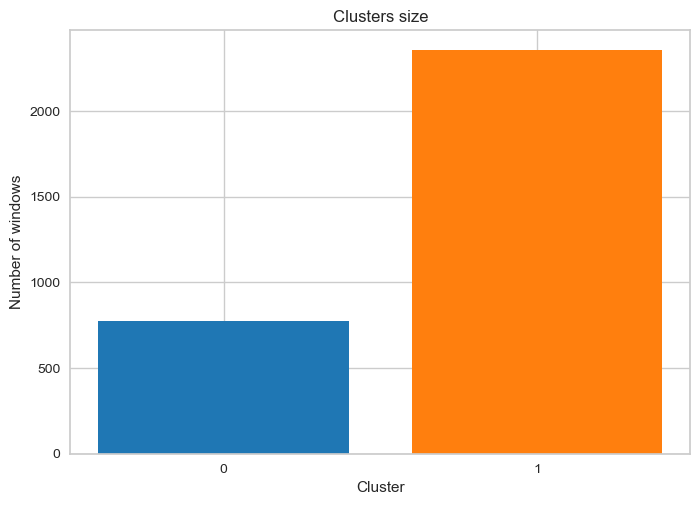

In [32]:
window_features_df["cluster"] = labels_window
counts = np.bincount(window_features_df["cluster"])
plt.bar(range(len(counts)), counts, color=sns.color_palette("tab10"))
plt.xticks(range(len(counts)))
plt.ylabel('Number of windows')
plt.xlabel('Cluster')
plt.title('Clusters size')
window_features_df.drop(columns="cluster", inplace=True)

Plotting the clusters in the PCA space:

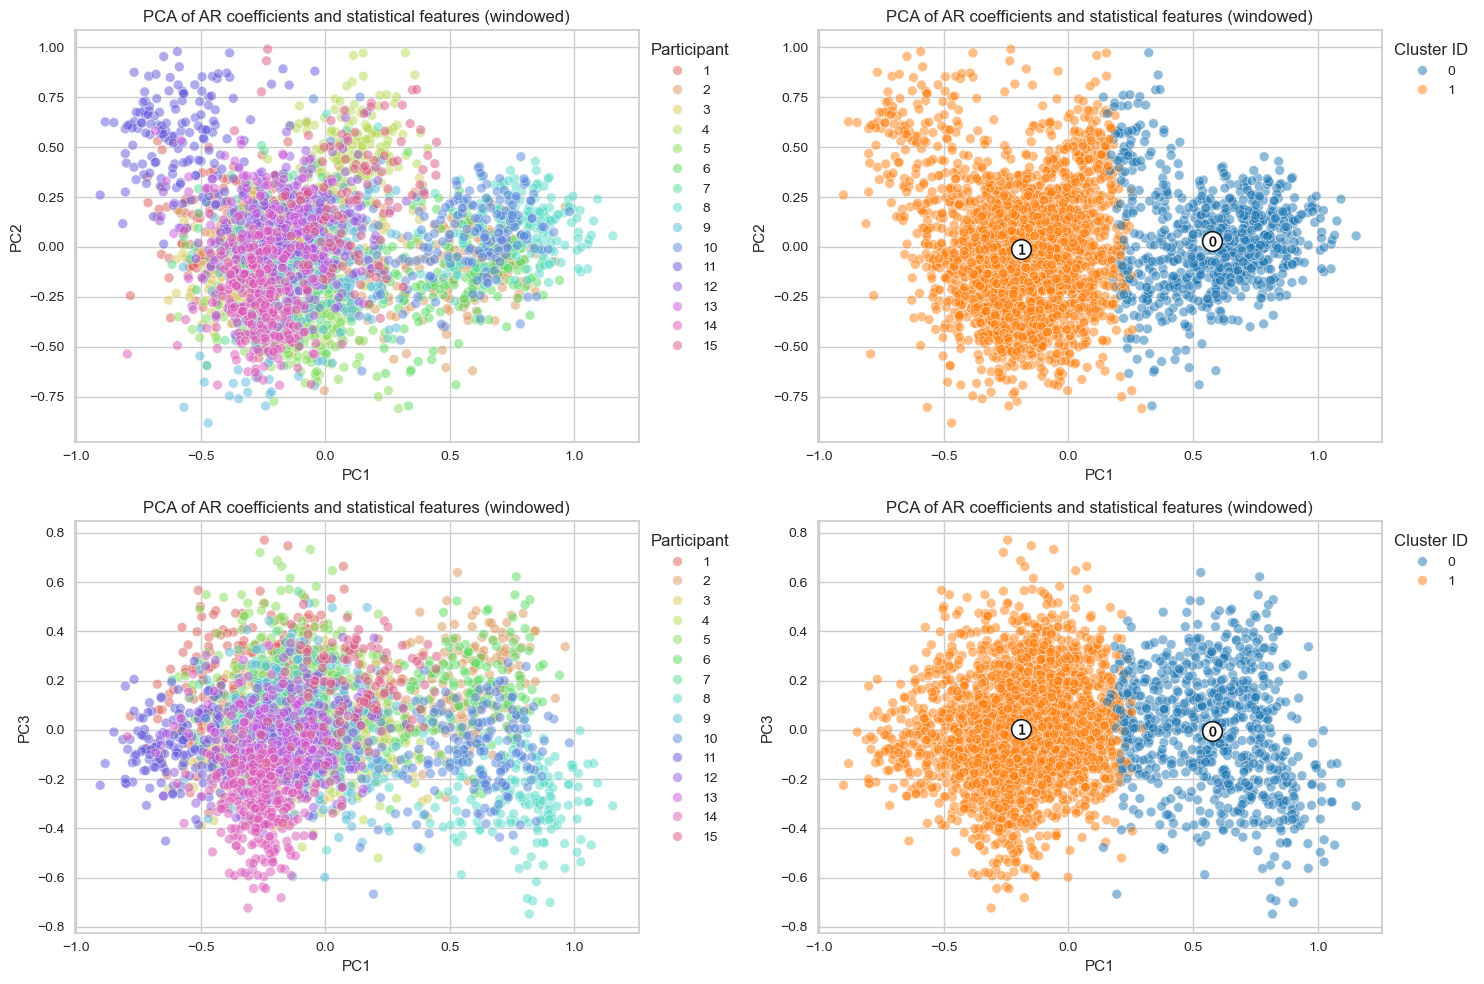

In [33]:
# computing PCA
window_coefs_PC = pca.fit_transform(window_features_scaled_df)
window_clusters_df = pd.DataFrame(kmeans_window.cluster_centers_, columns=window_features_scaled_df.columns)
window_centers_PC = pca.transform(window_clusters_df)
# plotting the first 3 principal components
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# 2D plot of the first and second principal components color-coded by participant
sns.scatterplot(x=window_coefs_PC[:, 0], y=window_coefs_PC[:, 1], hue=window_features_df['participant'], palette=sns.color_palette("hls", N_PARTICIPANTS), alpha=0.5, ax=axs[0][0])
axs[0][0].set_xlabel("PC1")
axs[0][0].set_ylabel("PC2")
axs[0][0].set_title("PCA of AR coefficients and statistical features (windowed)");
axs[0][0].legend(bbox_to_anchor=(1, 1), loc='upper left', title="Participant");
# 2D plot of the first and second principal components color-coded by cluster
sns.scatterplot(x=window_coefs_PC[:, 0], y=window_coefs_PC[:, 1], hue=labels_window, palette=sns.color_palette("tab10")[:nclusters_window], alpha=0.5, ax=axs[0][1])
# plotting centroids
sns.scatterplot(x=window_centers_PC[:, 0], y=window_centers_PC[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k', ax=axs[0][1])
for i in range(0, nclusters_window):
   axs[0][1].scatter(x=window_centers_PC[i, 0], y=window_centers_PC[i, 1], marker=f'${i}$', c='black', alpha=1, s=50, edgecolor='k')
axs[0][1].set_xlabel("PC1")
axs[0][1].set_ylabel("PC2")
axs[0][1].set_title("PCA of AR coefficients and statistical features (windowed)");
axs[0][1].legend(bbox_to_anchor=(1, 1), loc='upper left', title="Cluster ID");
# 2D plot of the first and third principal components color-coded by participant
sns.scatterplot(x=window_coefs_PC[:, 0], y=window_coefs_PC[:, 2], hue=window_features_df['participant'], palette=sns.color_palette("hls", N_PARTICIPANTS), alpha=0.5, ax=axs[1][0])
axs[1][0].set_xlabel("PC1")
axs[1][0].set_ylabel("PC3")
axs[1][0].set_title("PCA of AR coefficients and statistical features (windowed)");
axs[1][0].legend(bbox_to_anchor=(1, 1), loc='upper left', title="Participant");
# 2D plot of the first and second principal components color-coded by cluster
sns.scatterplot(x=window_coefs_PC[:, 0], y=window_coefs_PC[:, 2], hue=labels_window, palette=sns.color_palette("tab10")[:nclusters_window], alpha=0.5, ax=axs[1][1])
# plotting centroids
sns.scatterplot(x=window_centers_PC[:, 0], y=window_centers_PC[:, 2], marker='o', c='white', alpha=1, s=200, edgecolor='k', ax=axs[1][1])
for i in range(0, nclusters_window):
   axs[1][1].scatter(x=window_centers_PC[i, 0], y=window_centers_PC[i, 2], marker=f'${i}$', c='black', alpha=1, s=50, edgecolor='k')
axs[1][1].set_xlabel("PC1")
axs[1][1].set_ylabel("PC3")
axs[1][1].set_title("PCA of AR coefficients and statistical features (windowed)");
axs[1][1].legend(bbox_to_anchor=(1, 1), loc='upper left', title="Cluster ID");
fig.tight_layout()

We observe that within the PCA space, the clusters identified by KMeans are moderately separated.

Plotting the clusters in the t-SNE space:

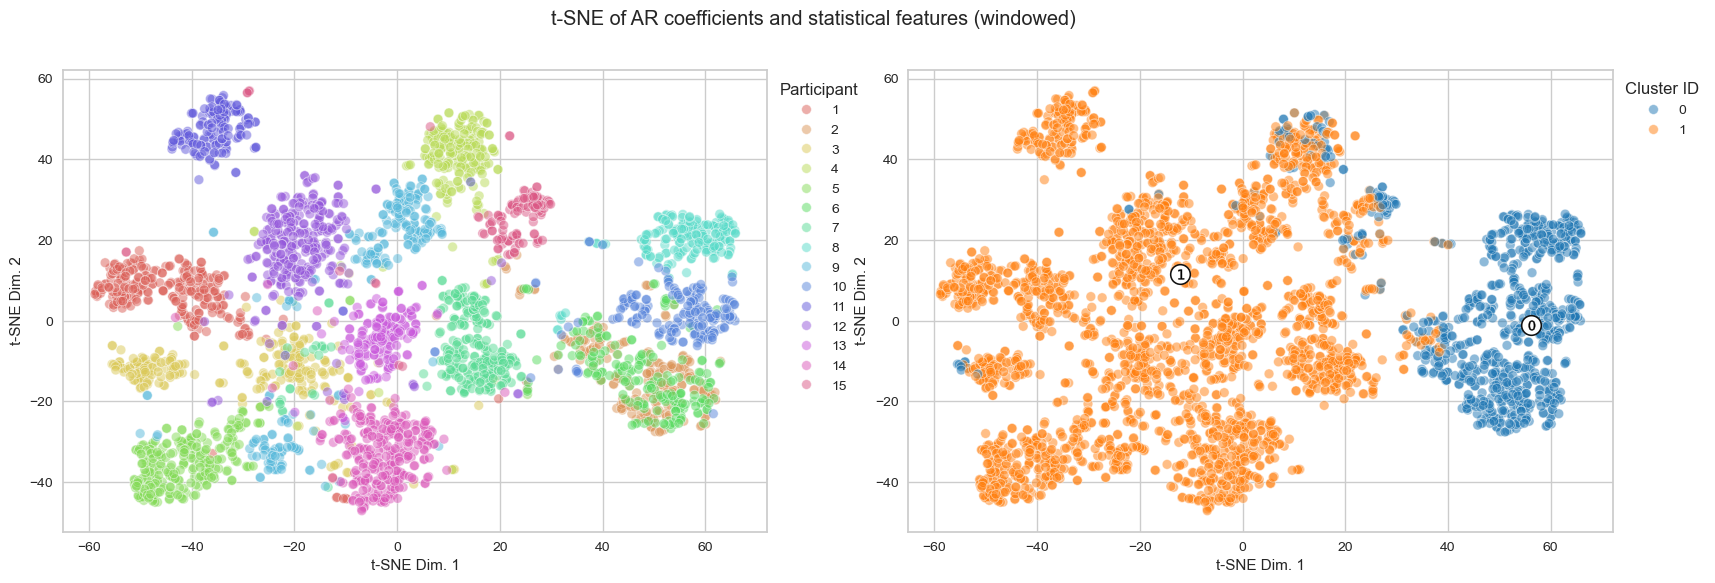

In [34]:
# computing t-SNE
tsne_window = TSNE(n_components=2, random_state=RANDOM_STATE)
features_tsne = tsne_window.fit_transform(np.concatenate((window_features_scaled, kmeans_window.cluster_centers_), axis=0))
features_tsne_windows = features_tsne[:window_features_scaled.shape[0]]
features_tsne_centers = features_tsne[window_features_scaled.shape[0]:]
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
# plotting t-SNE color-coded by participant
sns.scatterplot(x=features_tsne_windows[:, 0], y=features_tsne_windows[:, 1], hue=window_features_df['participant'], palette=sns.color_palette("hls", N_PARTICIPANTS), alpha=0.5, ax=axs[0])
axs[0].set_xlabel("t-SNE Dim. 1")
axs[0].set_ylabel("t-SNE Dim. 2")
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left', title="Participant");
# plotting t-SNE color-coded by cluster
sns.scatterplot(x=features_tsne_windows[:, 0], y=features_tsne_windows[:, 1], hue=labels_window, palette=sns.color_palette("tab10")[:nclusters_window], alpha=0.5, ax=axs[1])
# plotting centroids
sns.scatterplot(x=features_tsne_centers[:, 0], y=features_tsne_centers[:, 1], marker='o', c='white', alpha=1, s=200, edgecolor='k', ax=axs[1])
for i in range(0, nclusters_window):
    axs[1].scatter(x=features_tsne_centers[i, 0], y=features_tsne_centers[i, 1], marker=f'${i}$', c='black', alpha=1, s=50, edgecolor='k')
axs[1].set_xlabel("t-SNE Dim. 1")
axs[1].set_ylabel("t-SNE Dim. 2")
axs[1].legend(bbox_to_anchor=(1, 1), loc='upper left', title="Cluster ID");
fig.suptitle("t-SNE of AR coefficients and statistical features (windowed)");

In the t-SNE space, the clusters are quite separated, but still not perfectly. Furthermore, this visualization shows that points belonging to the same participant are often clustered together and separated from points belonging to other participants (with the exception of participant 2 and 6). This suggests that the features extracted effectively capture the differences among participants. The fact that each individual exhibits a unique walking pattern, as evidenced in the clustering, is consistent with the literature (see e.g. [here](https://www.researchgate.net/publication/227192676_Personalization_and_user_verification_in_wearable_systems_using_biometric_walking_patterns?ev=prf_pub)).

Visualizing the distribution of participants within the clusters:

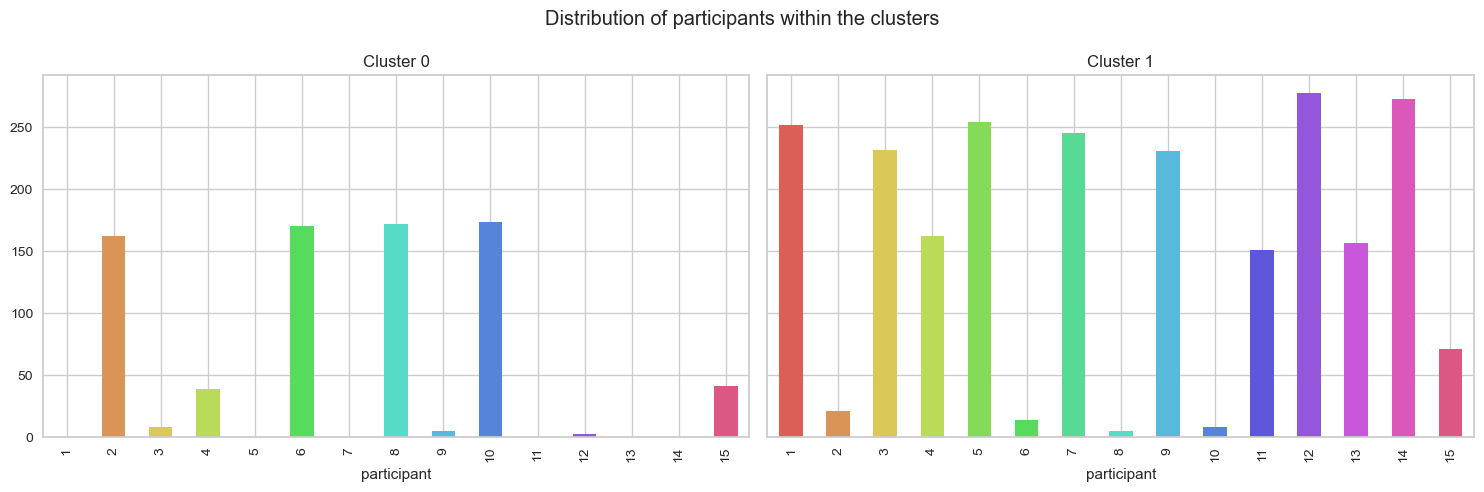

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
window_features_df["cluster"] = labels_window
for i in range(nclusters_window):
    cluster = window_features_df[window_features_df["cluster"]==i]
    counts = cluster["participant"].value_counts()
    counts = counts.reindex(range(1, N_PARTICIPANTS+1), fill_value=0)
    counts.plot(kind="bar", title=f"Cluster {i}", ax=axs[i], color=sns.color_palette("hls", N_PARTICIPANTS))
fig.suptitle('Distribution of participants within the clusters');
plt.tight_layout()

It is evident that cluster 0 contains most of the windows from participants 2, 6, 8 and 10. Windows from participant 15 are distributed across both clusters. This is consistent with the previous clustering results.

Inspecting the feature distribution within the clusters:

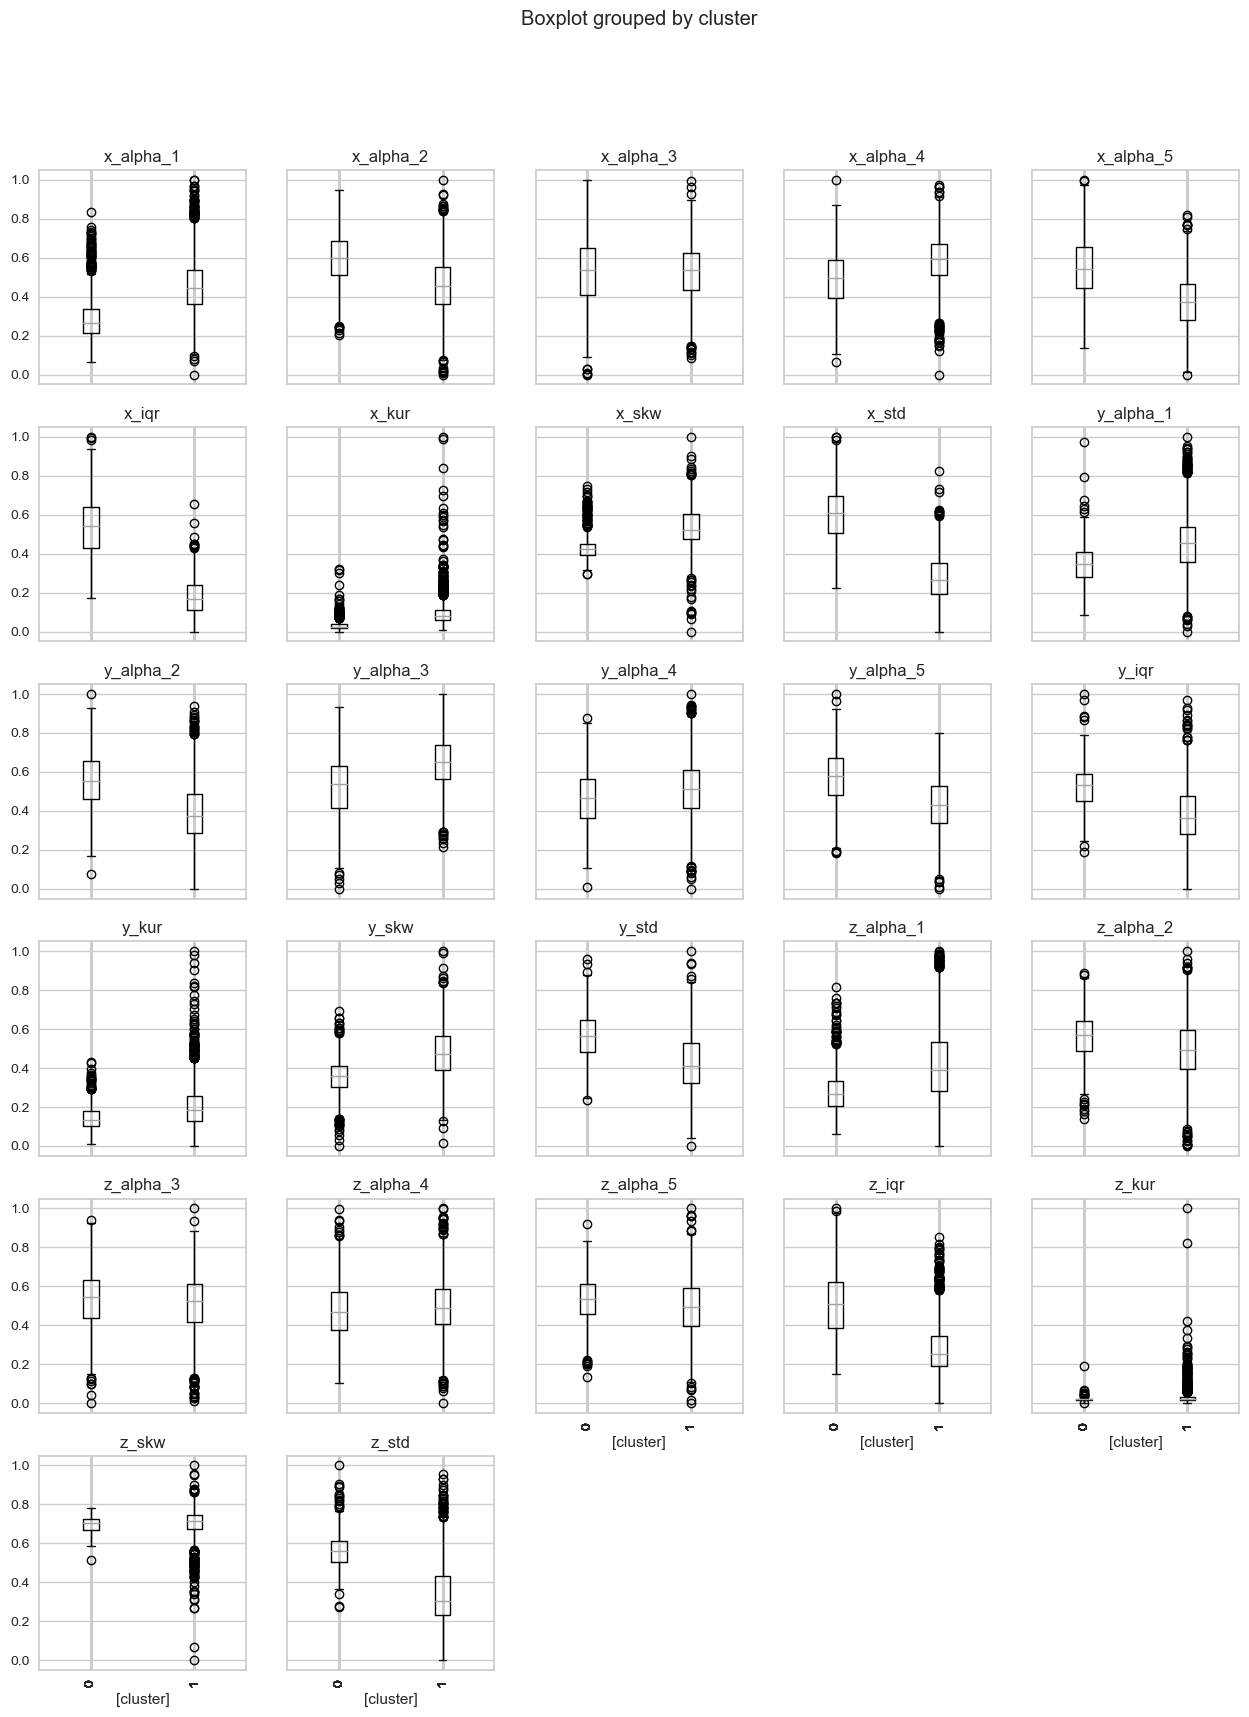

In [36]:
window_features_scaled_df["cluster"] = labels_window
window_features_scaled_df.boxplot(by="cluster", rot=90, figsize=(15, 20));
window_features_scaled_df.drop(columns=["cluster"], inplace=True)

Visualizing the clusters centroids:

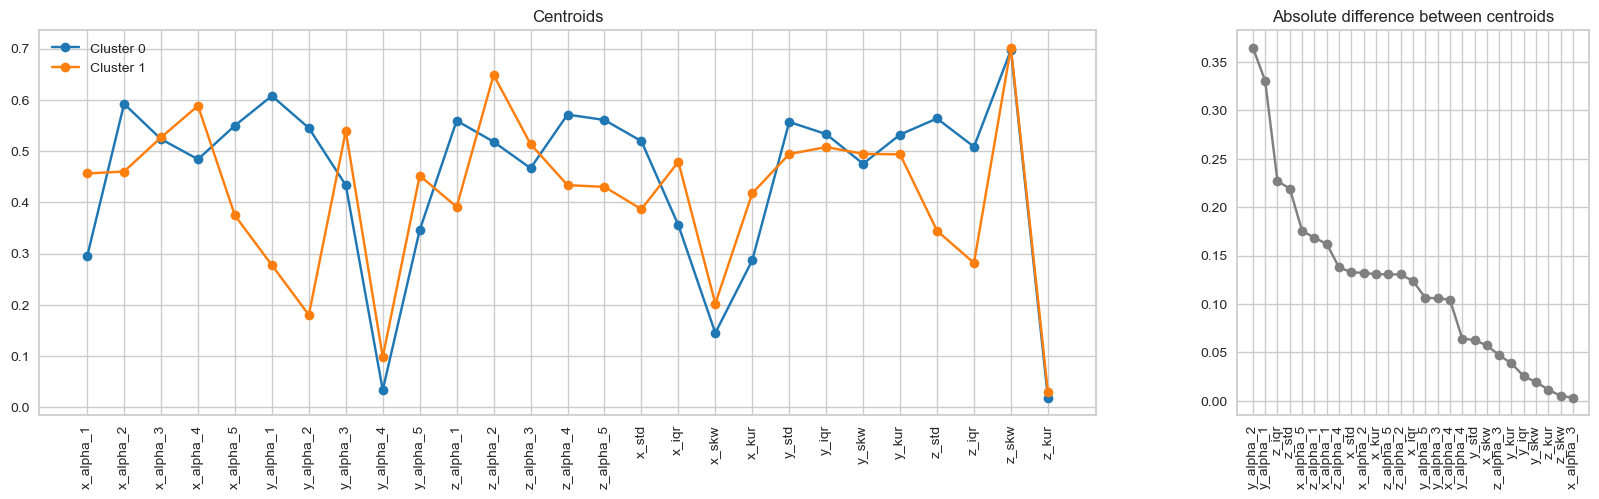

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [3, 1]})

for j in range(0, len(kmeans_window.cluster_centers_)):
    axs[0].plot(kmeans_window.cluster_centers_[j], marker='o', label='Cluster %s' % j, c=sns.color_palette('tab10')[j])
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].set_xticks(range(0, len(features_scaled_df.columns)), features_scaled_df.columns, rotation=90)
axs[0].legend();
axs[0].set_title(f'Centroids');

abs_diff = abs(kmeans_window.cluster_centers_[0]-kmeans_window.cluster_centers_[1])
sorted_idx = np.flip(np.argsort(abs_diff))
axs[1].plot(abs_diff[sorted_idx], '-o', c='gray')
axs[1].set_xticks(range(0, len(sorted_idx)), features_scaled_df.columns[sorted_idx], rotation=90);
axs[1].set_title("Absolute difference between centroids");

The features that most distinguish the centroids of the clusters are the AR coefficients of the y acceleration of orders 1 and 2, and the interquartile range and the standard deviation of the z acceleration.

## Considerations

AR coefficients and statistical features have proven to identify differences between participants. The consistency of the results across the analyses of the whole time series and the windows suggests that these features remain informative even when computed over extended time periods.

To improve the clustering scores, we could consider:
- Applying pre-processing techniques to remove noise and outliers (e.g., using smoothing average)
- Conducting a finer model selection for the orders of the ARIMA model to use as features, potentially incorporating trend and seasonal components
- Selecting a subset of features to perform the clustering
- Repeating the analysis with different window sizes to assess their impact on results
- Employing different clustering algorithms